In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder
import datetime
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("2013_Accidents_UK.csv")
df.shape


(138660, 36)

In [8]:
df.longitude

0        -0.171402
1        -0.173356
2        -0.210767
3        -0.209675
4        -0.194332
            ...   
138655   -2.957892
138656   -3.257179
138657   -3.443953
138658   -3.303648
138659   -3.482304
Name: longitude, Length: 138660, dtype: float64

# Helper Methods

In [9]:
## this method used to get the number of days in each month, we create this method for sake of cleaning the code 
def getNumberOfDaysInMonth(month):
    if ((month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12)):
        return 31
    if ((month == 4 or month == 6 or month == 9 or month == 11)):
        return 30
    if ((month == 2)):
        return 28

In [10]:
## this method used to validate the days corresponding to each month
## this used used in order to check the inconsistency for example if there exist date which is 31/2 this is considered invalid date
def validateDates(day,month):
    output = False
    if ((month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12)  and (day<32)):
        output = True
    if ((month == 4 or month == 6 or month == 9 or month == 11) and (day<31)):
        output = True
    if ((month == 2) and (day<=29)):
        output = True
    return output

In [11]:
## this method used to assign each number of day in a week to the day of the week will be used in order to check and hadle the inconsistency of the day 
## of week and the date
def assignDays(number):
    if number == 0:
        return "Monday"
    elif number == 1:
        return "Tuesday"
    elif number == 2:
        return "Wednesday"
    elif number == 3:
        return "Thursday"
    elif number == 4:
        return "Friday"
    elif number == 5:
        return "Saturday"
    elif number == 6:
        return "Sunday"

# Visualization

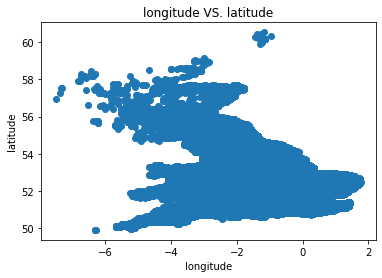

In [14]:
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('longitude VS. latitude')
plt.scatter(df["longitude"],df["latitude"])
plt.show()

To what extent does the light conditions effect the number of accidents

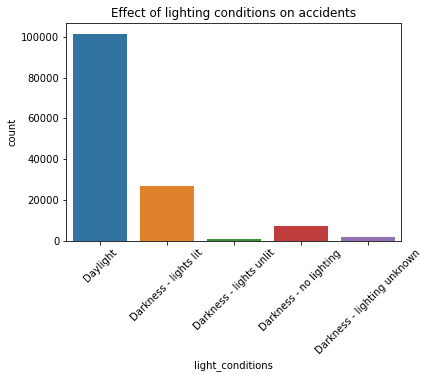

In [3]:
sns.countplot('light_conditions', data =df )
plt.title('Effect of lighting conditions on accidents')
plt.xticks(rotation=45)
plt.show()

To what extent does the area effect the number of accidents

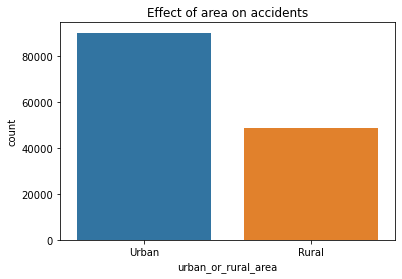

In [168]:
sns.countplot('urban_or_rural_area', data =df )
plt.title('Effect of area on accidents')
plt.show()


pedestrian_crossing_physical_facilities vs number of accidents

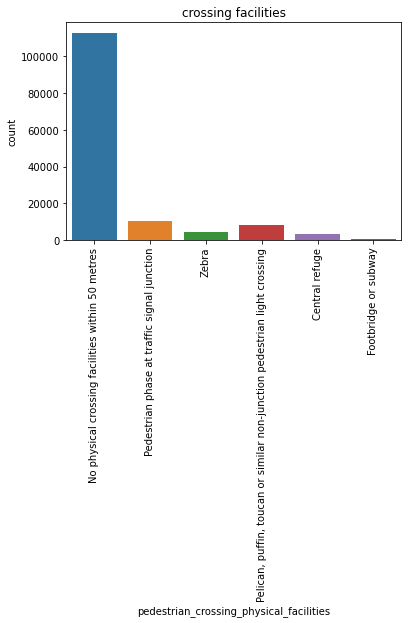

In [5]:
sns.countplot('pedestrian_crossing_physical_facilities', data =df )
plt.title('crossing facilities')
plt.xticks(rotation=90)
plt.show()


Effect of road type on accident occurence

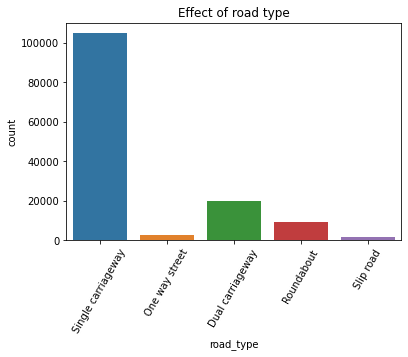

In [6]:
sns.countplot('road_type', data =df )
plt.title('Effect of road type')
plt.xticks(rotation=60)
plt.show()

Is there a relation between the speed limit and the number of accidents?

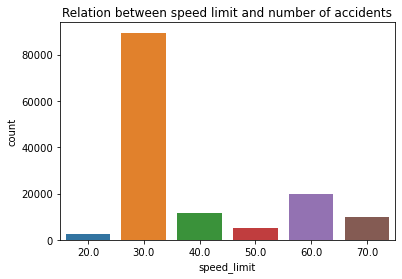

In [7]:
sns.countplot("speed_limit",data=df)
plt.title("Relation between speed limit and number of accidents")
plt.show()

Is there a relationship between the state of the accident and the road conditions

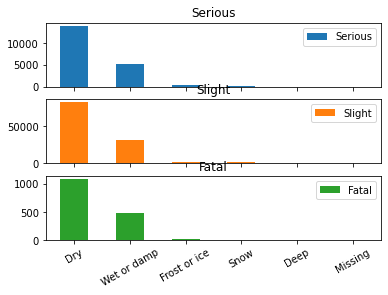

In [8]:
serious = df[df['accident_severity'] == "Serious"]
slight = df[df['accident_severity'] == "Slight"]
fatal = df[df['accident_severity'] == "Fatal"]

seriList = list(serious["road_surface_conditions"].value_counts().values)
sliList = list(slight["road_surface_conditions"].value_counts().values)
faList = list(fatal["road_surface_conditions"].value_counts().values)

index = ['Dry','Wet or damp','Frost or ice', 'Snow','Deep', 'Missing']
divisionDF = pd.DataFrame({'Serious':seriList,'Slight':sliList,'Fatal':faList},index=index)
ax = divisionDF.plot.bar(rot = 30, subplots=True)


# 1st level Cleaning

Trying to observe the missing values in every column using the technique below shows that there only 2 columns have missing values.

In [23]:
df_clean=df.copy()
df.isna().mean()*100


accident_index                                  0.000000
accident_year                                   0.000000
accident_reference                              0.000000
location_easting_osgr                           0.000000
location_northing_osgr                          0.000000
longitude                                       0.000000
latitude                                        0.000000
police_force                                    0.000000
accident_severity                               0.000000
number_of_vehicles                              0.000000
number_of_casualties                            0.000000
date                                            0.000000
day_of_week                                     0.000000
time                                            0.000000
local_authority_district                        0.000000
local_authority_ons_district                    0.000000
local_authority_highway                         0.000000
first_road_class               

However it is found as will be shown below that in some columns the missing values are camouflaged using -1 or the string "Missing" in order to explore the missing values and clean the data. Columns with camouflaged missing values will be converted to nulls. However it should be taken into consideration that -1 doesn't necessarily mean null in every column. It depends on the context and range of values of the column. Therefore each column will be observed and handled separately.

Each column was observed separately however for the sake of simplicity of the notebook only the columns that were found to conatin camouflaged missing values will be reported below. 


##### 1. Trunk Road Flag Column 

As shown below, in this column 14874 rows had a value of "Data missing or out of range". The column is an indicator of road type and hence the string is not a valid entry and should be cleaned by replacing all of its occurences with null. These values take around 10.7% of the column. 

In [24]:
print(df_clean['trunk_road_flag'].value_counts()) 
df_clean['trunk_road_flag'] = df_clean['trunk_road_flag'].replace('Data missing or out of range', np.nan)
print("Percentage of null values: ", df_clean["trunk_road_flag"].isnull().mean()*100 )
print(df_clean['trunk_road_flag'].value_counts()) 

Non-trunk                                    113646
Data missing or out of range                  14874
Trunk (Roads managed by Highways England)     10140
Name: trunk_road_flag, dtype: int64
Percentage of null values:  10.726958026828214
Non-trunk                                    113646
Trunk (Roads managed by Highways England)     10140
Name: trunk_road_flag, dtype: int64


##### 2. Carriageway Hazards Column

Similarly here, this column had "Data missing or out of range" as an entry and will also be replaced with null. Note here that "None" doesn't mean that the data is missing, it is one of the values of the column simply indicating that there were no carriageway hazards on the road during the accident. We can notice here that the column now appears to have null values.

In [25]:
print(df_clean['carriageway_hazards'].value_counts())
df_clean['carriageway_hazards'] = df_clean['carriageway_hazards'].replace('Data missing or out of range', np.nan)
print("Percentage of null values: ", df_clean["carriageway_hazards"].isnull().mean()*100 )
print(df_clean['carriageway_hazards'].value_counts())

None                                               136232
Other object on road                                  972
Any animal in carriageway (except ridden horse)       734
Pedestrian in carriageway - not injured               376
Previous accident                                     211
Vehicle load on road                                  133
Data missing or out of range                            2
Name: carriageway_hazards, dtype: int64
Percentage of null values:  0.0014423770373575653
None                                               136232
Other object on road                                  972
Any animal in carriageway (except ridden horse)       734
Pedestrian in carriageway - not injured               376
Previous accident                                     211
Vehicle load on road                                  133
Name: carriageway_hazards, dtype: int64


##### 3. Junction Detail

Similarly here, this column had "Data missing or out of range" as an entry and will also be replaced with null. Fortunately, the percentage of missing values is low. 

In [26]:
print(df_clean['junction_detail'].value_counts()) 
df_clean['junction_detail'] = df_clean['junction_detail'].replace('Data missing or out of range', np.nan)
print("Percentage of null values: ",df_clean["junction_detail"].isnull().mean()*100)
print(df_clean['junction_detail'].value_counts()) 

Not at junction or within 20 metres    54693
T or staggered junction                44334
Crossroads                             13692
Roundabout                             12439
Private drive or entrance               5516
Other junction                          2984
Slip road                               1972
Mini-roundabout                         1796
More than 4 arms (not roundabout)       1226
Data missing or out of range               8
Name: junction_detail, dtype: int64
Percentage of null values:  0.005769508149430261
Not at junction or within 20 metres    54693
T or staggered junction                44334
Crossroads                             13692
Roundabout                             12439
Private drive or entrance               5516
Other junction                          2984
Slip road                               1972
Mini-roundabout                         1796
More than 4 arms (not roundabout)       1226
Name: junction_detail, dtype: int64


##### 4. Junction Control

In [27]:
print(df_clean['junction_control'].value_counts())
df_clean['junction_control'] = df_clean['junction_control'].replace('Data missing or out of range', np.nan)
print("Percentage of null values: ",df_clean["junction_control"].isnull().mean()*100)
print(df_clean['junction_control'].value_counts())

Give way or uncontrolled        68517
Data missing or out of range    54808
Auto traffic signal             14474
Stop sign                         676
Authorised person                 185
Name: junction_control, dtype: int64
Percentage of null values:  39.52690033174672
Give way or uncontrolled    68517
Auto traffic signal         14474
Stop sign                     676
Authorised person             185
Name: junction_control, dtype: int64


##### 5. Second Road Class

Here, the string 'Data missing or out of range' is not present. However -1 is presumed to be a missing value that will be replaced will null. Moreover, it should be noted that the value 'Unclassified' is itself a road class in UK, it doesn't mean that the class classification is missing.

In [28]:
print(df_clean["second_road_class"].value_counts()) 
df_clean['second_road_class'] = df_clean['second_road_class'].replace('-1', np.nan)
print("Percentage of null values: ",df_clean["second_road_class"].isnull().mean()*100) #40.302899177845084% null
print(df_clean["second_road_class"].value_counts()) 

-1              55884
Unclassified    55719
A               13890
C                6599
B                5576
Motorway          905
A(M)               87
Name: second_road_class, dtype: int64
Percentage of null values:  40.302899177845084
Unclassified    55719
A               13890
C                6599
B                5576
Motorway          905
A(M)               87
Name: second_road_class, dtype: int64


##### 6. Did Police Officer Attend

In [29]:
print(df_clean["did_police_officer_attend_scene_of_accident"].value_counts()) #1 entry including "Data missing or out of range'
df_clean['did_police_officer_attend_scene_of_accident'].replace('Data missing or out of range', np.nan, inplace=True)
print(df_clean["did_police_officer_attend_scene_of_accident"].value_counts()) 

Yes                             113358
No                               25301
Data missing or out of range         1
Name: did_police_officer_attend_scene_of_accident, dtype: int64
Yes    113358
No      25301
Name: did_police_officer_attend_scene_of_accident, dtype: int64


##### 7. LSOA of accident location

This column is another example of why each column should be observed separately. As shown below, the missing values here are encoded as "-1" and -1. Both entries represent missing values and will converted to null. Around 7% of this column is found to be missing.

In [30]:
print(df_clean["lsoa_of_accident_location"].value_counts() )
df_clean['lsoa_of_accident_location'].replace('-1', np.nan, inplace=True)
df_clean['lsoa_of_accident_location'].replace(-1, np.nan, inplace=True)
df_clean["lsoa_of_accident_location"].value_counts() 
print("Missing Percentage: ",df_clean['lsoa_of_accident_location'].isnull().mean()*100 )# 7.04% missing
print(df_clean["lsoa_of_accident_location"].value_counts() )

-1           7588
-1           2176
E01032739     206
E01004736     155
E01033595     108
             ... 
E01027979       1
E01028248       1
E01027938       1
E01028267       1
E01014191       1
Name: lsoa_of_accident_location, Length: 28787, dtype: int64
Missing Percentage:  7.041684696379634
E01032739    206
E01004736    155
E01033595    108
E01004689     79
E01002444     71
            ... 
E01019523      1
E01019418      1
E01019625      1
E01019642      1
W01000479      1
Name: lsoa_of_accident_location, Length: 28785, dtype: int64


##### 8. Local Authority Highway

The local authority highway column includes a list of "cities"/"areas" in UK where the accidents occured. The missing value in this column was represented as a string "-1" which should be replaced. 

In [31]:
print(df_clean.local_authority_highway.unique())
df_clean.local_authority_highway.replace('-1', np.nan, inplace=True)
df_clean['local_authority_highway'].isnull().mean()*100 #0.6565% missing

['Kensington and Chelsea' 'Westminster' 'Hammersmith and Fulham'
 'City of London' 'Tower Hamlets' 'Hackney' 'Camden' 'Southwark'
 'Islington' 'Brent' 'Ealing' 'Haringey' 'Richmond upon Thames' 'Hounslow'
 'Wandsworth' 'Newham' 'London Airport (Heathrow)' 'Hillingdon'
 'Waltham Forest' 'Enfield' 'Redbridge' 'Barking and Dagenham' 'Havering'
 'Croydon' 'Lambeth' 'Bexley' 'Lewisham' 'Greenwich' 'Bromley' 'Harrow'
 'Barnet' 'Merton' 'Kingston upon Thames' 'Sutton' 'Cumbria' 'Lancashire'
 'Blackpool' 'Blackburn with Darwen' 'Wirral' 'Sefton' 'Liverpool'
 'Knowsley' 'St. Helens' 'Manchester' 'Salford' 'Tameside' 'Stockport'
 'Bolton' 'Wigan' 'Trafford' 'Bury' 'Rochdale' 'Oldham'
 'Cheshire West and Chester' 'Halton' 'Warrington' 'Cheshire East'
 'Gateshead' 'North Tyneside' 'Newcastle upon Tyne' 'Northumberland'
 'Sunderland' 'South Tyneside' 'County Durham' 'Darlington'
 'North Yorkshire' 'York' 'Leeds' 'Kirklees' 'Bradford' 'Wakefield'
 'Calderdale' 'Sheffield' 'Rotherham' 'Doncaster' 'Ba

0.643300158661474

##### 9. Date

Columns should contain atomic propertiues, hence the date column will be replaced with 2 columns day & month since column year already exists. This will cause the dimensionality of the dataset to increase by 1 since we are replacing 1 column with 2 columns

In [32]:
print("Dataframe shape before splitting and dropping: ", df_clean.shape)
df_clean['date']=  pd.to_datetime(df['date'])
df_clean["day"] = df_clean['date'].map(lambda x: x.day)
df_clean["month"] = df_clean['date'].map(lambda x: x.month)
df_clean = df_clean.drop(['date'], axis = 1)
print("Dataframe shape after splitting and dropping: ", df_clean.shape)

Dataframe shape before splitting and dropping:  (138660, 36)
Dataframe shape after splitting and dropping:  (138660, 37)


The column year could be dropped since all accidents occurred in the same year. 

In [33]:
print("Dataframe shape before dropping: ", df_clean.shape)
df_clean = df_clean.drop(['accident_year'], axis = 1)
print("Dataframe shape after dropping: ",df_clean.shape )

Dataframe shape before dropping:  (138660, 37)
Dataframe shape after dropping:  (138660, 36)


##### 10. Time

Columns should contain atomic properties, therefore the time column could be splitted to hours and minutes however we're going to extract the hours only. As if the data is discretized into hours. As shown below by printing the first 5 entries of hour & time, the hour was extracted succeffully from the time column. The time column will then be dropped 

In [34]:
print("Dataframe shape before splitting and dropping: ", df_clean.shape)
df_clean['hour']=  df_clean['time'].map(lambda x: datetime.datetime.strptime(x, "%H:%M").hour)
df_clean[{'hour', 'time'}].head()
df_clean = df_clean.drop(['time'], axis = 1)
print("Dataframe shape after splitting and dropping: ", df_clean.shape)
df_clean['hour']


Dataframe shape before splitting and dropping:  (138660, 36)
Dataframe shape after splitting and dropping:  (138660, 36)


0          9
1          8
2         11
3         10
4         17
          ..
138655    11
138656    12
138657    10
138658    13
138659    20
Name: hour, Length: 138660, dtype: int64

# Handling Duplicates

Each accident has a unique accident index checking for duplicate entries, yields that no duplicate data was found. 

In [35]:
print(len(df_clean['accident_index'].unique())/len(df_clean)*100)
print(len(df_clean['accident_reference'].unique())/len(df_clean)*100)

100.0
100.0


As illustrated below the distribution of the data points of longitude and latitude appears to be the exact same distribution as the data points of location_easting_osgr and location_northing_osgr. The only difference is in the range of the data since both are different representations of location. Therefore these columns are redundant since the same information could be retrieved from only 2 columns instead of 4.

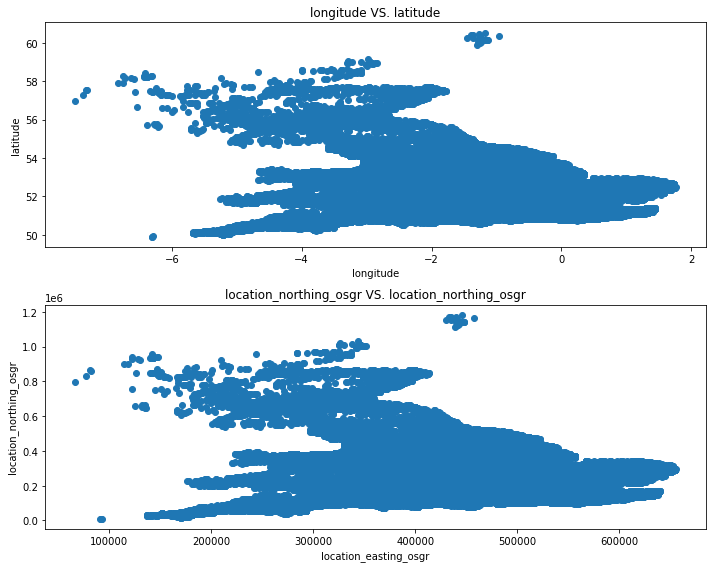

In [318]:
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[0].set_title('longitude VS. latitude')
ax[0].scatter(df_clean["longitude"],df_clean["latitude"])

ax[1].set_xlabel('location_easting_osgr')
ax[1].set_ylabel('location_northing_osgr')
ax[1].set_title('location_northing_osgr VS. location_northing_osgr')
ax[1].scatter(df_clean["location_easting_osgr"],df_clean["location_northing_osgr"])
fig.tight_layout()
plt.show()


In [36]:
print("Dataframe shape before dropping: ", df_clean.shape)
df_clean = df_clean.drop("location_northing_osgr", axis =1)
df_clean = df_clean.drop("location_easting_osgr", axis =1)
print("Dataframe shape after dropping: ", df_clean.shape)

Dataframe shape before dropping:  (138660, 36)
Dataframe shape after dropping:  (138660, 34)


Moreover, the column local_authority_ons_district and the column local_authority_district seem to be duplicates. By observing the rows where the 2 columns has different entries, it was found that they were indeed the same but with different formats of the district name as shown below. 

In [37]:
df_clean[{'local_authority_ons_district','local_authority_district'}].query('local_authority_district != local_authority_ons_district')

,local_authority_ons_district,local_authority_district
64944,Stratford-on-Avon,Stratford-upon-Avon
64945,Stratford-on-Avon,Stratford-upon-Avon
64946,Stratford-on-Avon,Stratford-upon-Avon
64951,Stratford-on-Avon,Stratford-upon-Avon
64954,Stratford-on-Avon,Stratford-upon-Avon
...,...,...
134288,City of Edinburgh,"Edinburgh, City of"
134289,City of Edinburgh,"Edinburgh, City of"
134291,City of Edinburgh,"Edinburgh, City of"
134294,City of Edinburgh,"Edinburgh, City of"


The correlation matrix below also shows the high correlation between the 3 columns 'local_authority_ons_district','local_authority_district' and 'local_authority_highway', however local_authority_highway is not redundant. A local authority highway contains several local authority districts so it doesn't make sense from the business logic to remove it even if statistics say otherwise. 

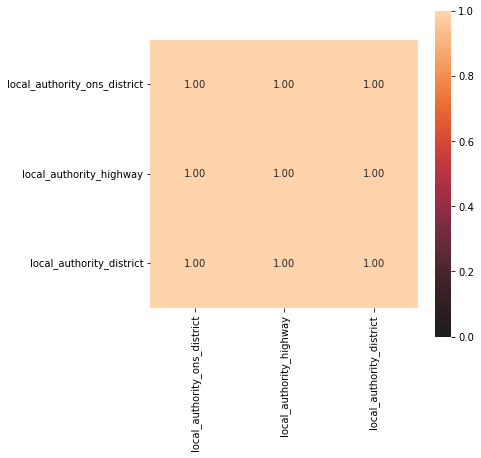

In [25]:
categorical_correlation= associations(df_clean[{'local_authority_ons_district','local_authority_district', 'local_authority_highway'}],figsize=(6,6))

In [38]:
print("Dataframe shape before dropping: ", df_clean.shape)
df_clean = df_clean.drop("local_authority_ons_district", axis =1)
print("Dataframe shape after dropping: ", df_clean.shape)

Dataframe shape before dropping:  (138660, 34)
Dataframe shape after dropping:  (138660, 33)


# Observing Missing Values

#### Visualizing missing values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


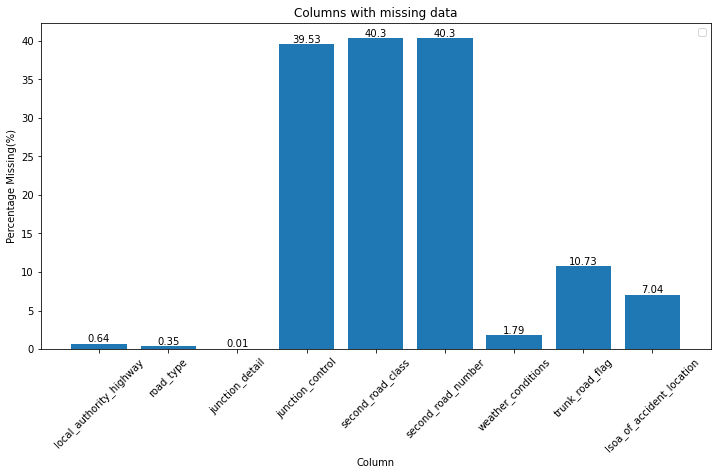

In [21]:
percent_missing = round(df_clean.isnull().mean() * 100,2) 
missing = percent_missing [percent_missing>0]
fig, ax = plt.subplots(figsize=(12, 6))
p1 = ax.bar(missing.index, missing)
ax.set_xlabel("Column")
plt.title("Columns with missing data")
plt.ylabel("Percentage Missing(%)")
ax.set_xticklabels(missing.index , rotation = 45)
ax.legend()
ax.bar_label(p1, label_type='edge')
plt.show()

<AxesSubplot:>

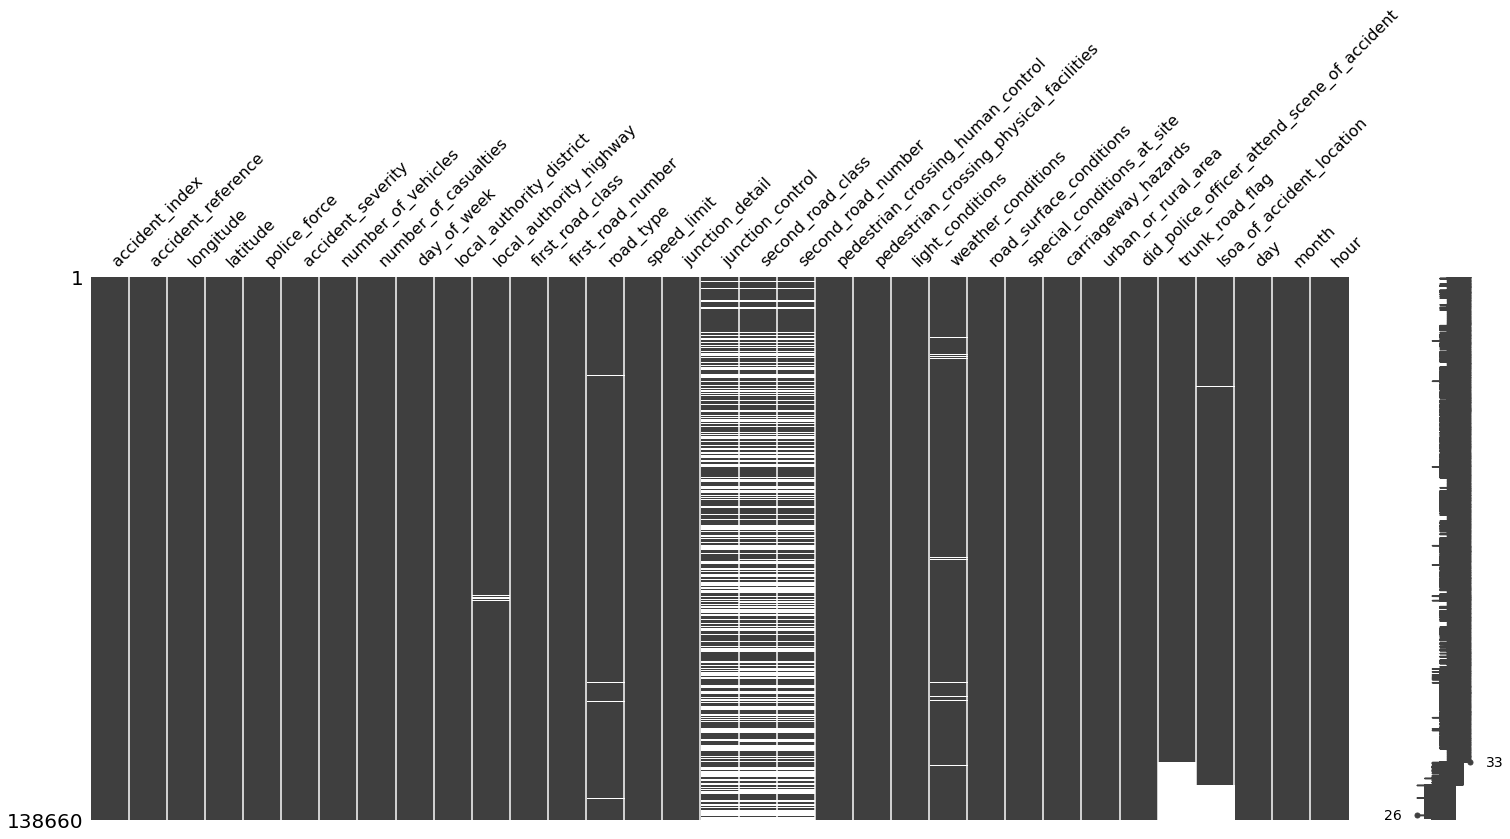

In [22]:
msno.matrix(df_clean)

#### 1. Junction Control, Second Road Number & Second Road Class (MAR)


The matrix illustrated above shows a correlation in the missing values of "junction_control", "second_road_number" & "second_road_class". Whenever there was no junction, then by default there doesn't exist a second road that the accident occured at. Since there is a missing pattern in the data and other observed columns (junction_detail) explain the pattern then they are missing at random (MAR)

#### 2. LSOA of accident location (MNAR)

Around 7% of the "lsoa_of_accident_location" is missing. When plotting the longitude and latude in the scatter plot. The red dots represent longitudes & latitudes with a corresponding lsoa area assigned. The pattern shows that the missing mechanism was not random. A consecutive group of areas where not assigned their LSOA. There is a pattern and other observed columns do not explain the pattern. Therefore it is thought of as missing not at random. (MNAR)
It was found that only the LSOA of areas that reside in Englad and Wales were recorded. Any accident that occured outside of England/ Wales had missing values 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

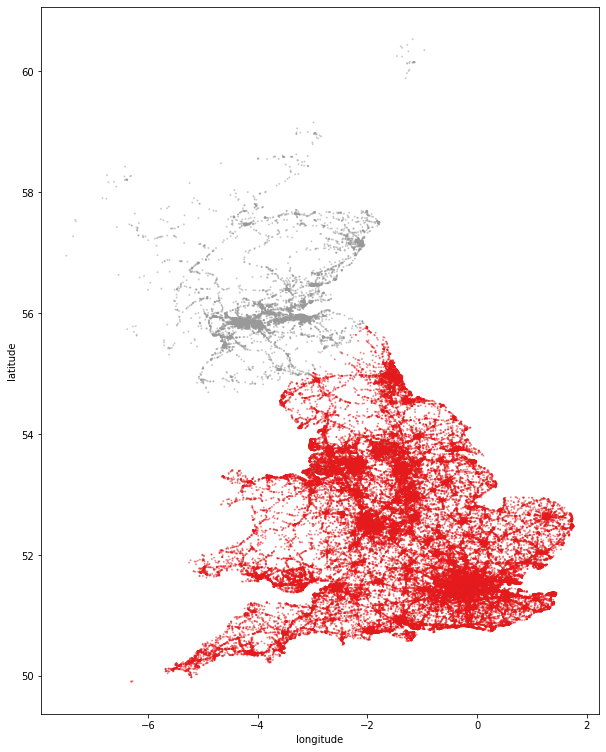

In [21]:
df_clean['is_assigned_lsoa_area'] =  df_clean['lsoa_of_accident_location'].isna()
df_clean.plot(kind="scatter", x="longitude", y="latitude", figsize = (10,13), alpha=0.4,s=1,
            c=df_clean["is_assigned_lsoa_area"], cmap=plt.get_cmap("Set1"), colorbar=False,
            sharex=False)

#### 3. Trunk Road Flag (MNAR)

The missing data is trunk_road_flag is observed to be missing not at random (MNAR)
The trunk road flag is an indicator of whether this road is a highway or not. There is a missing pattern in the data, the missing mechanism is not random as shown earlier in the matrix above the last consecutive 10% of the data is missing therefore there is a pattern because the missing rows are not randomly distributed aross the rows.  When comparing the road with the rest of the columns no correlation is found and the missing pattern could not be deciphered therefore it is assumed to be missing not at random. Missing Mechanism: Furthermore, after more explorations, the graph below shows that the missing values occured at Wales and Scotland. Trunk-Road-Flag has values for all accidents that occured in England only.

In [178]:
df_clean['trunk_road_flag'].value_counts()/len(df_clean)*100

False    81.916423
True      7.341201
Name: trunk_road_flag, dtype: float64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

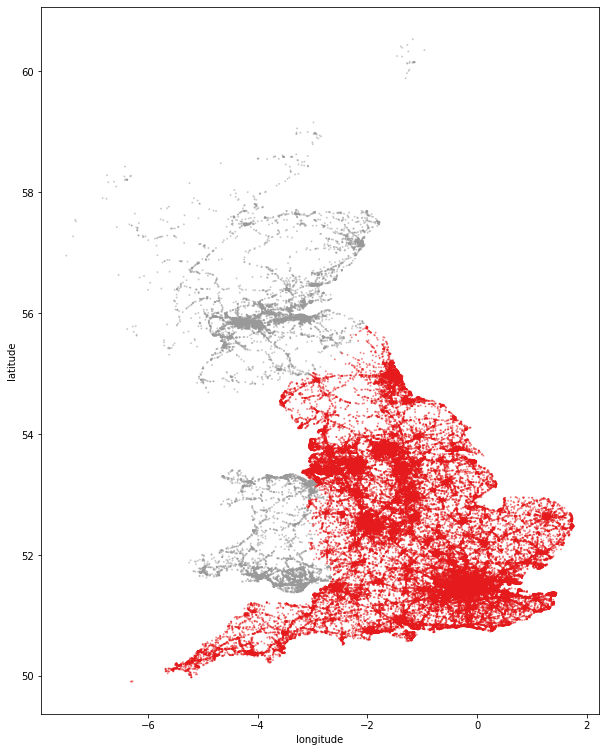

In [174]:
df_clean.plot(kind="scatter", x="longitude", y="latitude", figsize = (10,13), alpha=0.4,s=1,
            c= df_clean['trunk_road_flag'].isna(), cmap=plt.get_cmap("Set1"), colorbar=False,
            sharex=False)

#### 4. Local Authority Highway, Road Type, Junction Detail & Weather Conditions (MCAR)

The matrix illustrated above shows that the missing pattern of Local Authority Highway, Road Type, Junction Detail & Weather Conditions is completely at random. There is no relation with any of the observed data and there is no pattern, the missing percentage is very low and very random.

# Observing Date Inconsistencies

Observing the inconsistency between the column representing the datetime of the accident and the column day of week yields that there are some inconsistency. For example the date (21/3/2013) has a corresponding value in the dataset that it is a Wednesday when actually it is a Friday. 

In [23]:
def checkingForInconsistency():
    dayColumn = df_clean["day"]
    monthColumn = df_clean["month"]
    dayOfWeekColumn = df_clean["day_of_week"]
    month = 0
    day = 0
    newColumns = []
    for i in range(len(dayColumn)):
        day = dayColumn.iloc[i]
        month = monthColumn.iloc[i]
        if(day<10):
            day = day%10
        if(month<10):
            month = month%10
        validDate = validateDates(day=day,month=month)
        if validDate == True:
            dateTime = datetime.datetime(2013, month, day)
            dayOfDate = dateTime.weekday()
            if assignDays(dayOfDate) == dayOfWeekColumn.iloc[i]:
                newColumns.insert(i, True)
            else:
                newColumns.insert(i, False)

    tempDataFrame = pd.DataFrame({'checks':newColumns})
    return len(tempDataFrame[tempDataFrame["checks"] == False])/len(tempDataFrame)

In [25]:
checkingForInconsistency()

0.3338958603779028

using the block above we found that 33% of the dates doesn't correspond to the days of the week mentioned in column day of week, we also found that all the dates in the column are valid so we assume that the date is right and the problem is in the day of the week.

# Handling Unclean Data

 


### **Handling Noise & Inconsistencies**

#### Date Inconsistency

In [40]:
## here we handled the inconsistency mentioned above
dayColumn = df_clean["day"]
monthColumn = df_clean["month"]
dayOfWeekColumn = df_clean["day_of_week"]
month = 0
day = 0
for i in range(len(dayColumn)):
    day = dayColumn.iloc[i]
    month = monthColumn.iloc[i]
    if(day<10):
        day = day%10
    if(month<10):
        month = month%10
    dateTime = datetime.datetime(2013, month, day)
    dayOfDate = dateTime.weekday()
    actualDay = assignDays(dayOfDate)
    if actualDay != dayOfWeekColumn.iloc[i]:
       df_clean.loc[i,'day_of_week'] = actualDay

As shown below the data is now fully consistent

In [25]:
checkingForInconsistency()

0.0

#### Trunk Road Flag

Each road in UK has a unique road class and road number. The dataset has a column "trunk_road_flag" which indicates whether this road is a trunk one or not. Therefore if we grouped by the road number & road class we should expect 1 unique entry in the trunk road column indicating whether this road is trunk or not. However, as shown below, some roads where marked sometimes as trunk and sometimes as non-truk. This indicates inconsistency. Fortunately these rows are only 0.09% and hence could be dropped.

As shown below, 127 roads in the dataset were classified one time as Trunk and one time as Non-Trunk. We have 3467 unique roads, therefore around 3% of the roads are ambiguous. Accidents that occured on these roads should be dropped because data of these accidents are inconsistent.

In [42]:
not_null_trunk = df_clean[df_clean.trunk_road_flag.notna()]
df_road = not_null_trunk.groupby(['first_road_class', 'first_road_number'])
print("Total number of unique roads: ", len(df_road))
x = df_road['trunk_road_flag'].nunique()>1
inconsistent_roads = x[x==True]
inconsistent_roads.keys()


Total number of unique roads:  3467


MultiIndex([(       'A',    '1'),
            (       'A',   '10'),
            (       'A', '1001'),
            (       'A', '1033'),
            (       'A', '1036'),
            (       'A',   '11'),
            (       'A', '1168'),
            (       'A',   '12'),
            (       'A',  '120'),
            (       'A',  '126'),
            ...
            (    'A(M)',   '38'),
            ('Motorway',    '1'),
            ('Motorway',   '27'),
            ('Motorway',  '275'),
            ('Motorway',    '4'),
            ('Motorway',    '5'),
            ('Motorway',   '53'),
            ('Motorway',    '6'),
            ('Motorway',   '62'),
            ('Motorway',   '65')],
           names=['first_road_class', 'first_road_number'], length=127)

In [43]:
print("Dataframe shape before dropping inconsistent rows: ", df_clean.shape)
inconsistent_roads.keys()
for key in inconsistent_roads.keys():
    entries_to_drop = df_clean[(df_clean['first_road_class'] == key[0]) & (df_clean['first_road_number'] == key[1])].index
    df_clean = df_clean.drop(entries_to_drop)

print("Dataframe shape after dropping inconsistent rows: ", df_clean.shape)


Dataframe shape before dropping inconsistent rows:  (138660, 33)
Dataframe shape after dropping inconsistent rows:  (114555, 33)


As shown above, the number of rows with inconsistent data were dropped, although the number is too much. However it is better to have a smaller dataset where the data is clean and consistent than to have a large dataset with conflicting and contradicting information which confuses the model.

### **Filling Missing Values**

#### 1. Dropping rows where missing % is <2% and the missing pattern is assumed to be MCAR

Columns with missing values <2% were chosen to be dropped. Imputations are not accurate and they might produce inconsistency/ false information to the dataset. Therefore it is better to drop these rows as long as the percentage of missing values is low.
Column : road_surface_conditions => 0.19% missing

In [48]:
print("Dataframe shape before dropping" ,df_clean.shape)
df["road_surface_conditions"].unique() # 6 values including "Data missing or out of range"
df_clean.replace('Data missing or out of range', np.nan, inplace=True )
sum_null = df_clean.road_surface_conditions.isnull().mean()*100  #0.19% of data missing (MCAR)
df_clean.dropna(axis='index', subset=['road_surface_conditions'], inplace=True) # drop columns with null
print("Dataframe shape after dropping" ,df_clean.shape)

Dataframe shape before dropping (114555, 33)
Dataframe shape after dropping (114322, 33)


Column: road_type => 0.321% missing

In [49]:
print("Dataframe shape before dropping" ,df_clean.shape)
df["road_type"].unique() # 6 unique values including nan
sum_null = df_clean.road_type.isnull().mean()*100 #0.321% of data missing (MCAR)
df_clean.dropna(axis='index', subset=['road_type'], inplace=True) #drop the null values
print("Dataframe shape after dropping" ,df_clean.shape)

Dataframe shape before dropping (114322, 33)
Dataframe shape after dropping (113874, 33)


Column: weather_conditions => 1.786% missing

In [50]:
df["weather_conditions"].value_counts()
print("Dataframe shape before dropping" ,df_clean.shape)
print( "Percentage of missing: ",df["weather_conditions"].isnull().mean()*100) #1.786% of the data missing
df_clean.dropna(axis='index', subset=['weather_conditions'], inplace=True)
print("Percentage of missing after dropping:" ,df_clean["weather_conditions"].isnull().mean()*100)
print("Dataframe shape after dropping" ,df_clean.shape)

Dataframe shape before dropping (113874, 33)
Percentage of missing:  1.7863839607673446
Percentage of missing after dropping: 0.0
Dataframe shape after dropping (111976, 33)


Column: did_police_officer_attend_scene_of_accident => one null value

In [51]:
print("Dataframe shape before dropping" ,df_clean.shape)
df["did_police_officer_attend_scene_of_accident"].unique() # 6 values including "Data missing or out of range'
df_clean['did_police_officer_attend_scene_of_accident'].replace('Data missing or out of range', np.nan, inplace=True)
print( "Percentage of missing: ", df_clean["did_police_officer_attend_scene_of_accident"].isnull().sum()) # 1 null column
df_clean.dropna(axis='index', subset=['did_police_officer_attend_scene_of_accident'], inplace=True) #drop the column
print("Dataframe shape after dropping" ,df_clean.shape)

Dataframe shape before dropping (111976, 33)
Percentage of missing:  0
Dataframe shape after dropping (111976, 33)


#### 3. Local Authority District

Local Authority District column could be use to impute the Local Authority Highway. A local authority highway could include several local authority districts.
As seen all the missing local authority highway entries have a local district (Suffolk Coastal, Waveney, St. Edmundsbury  & Forest Heath ) which lie in Suffolk which is already one of the already existing attributes of Local_authority_highway.
Therefore all null values of local authority highway will be imputed with value 'Suffolk'

In [52]:
missing_local_highway = df_clean[df_clean.local_authority_highway.isna()]
missing_local_highway.police_force.unique()


array(['Suffolk'], dtype=object)

In [53]:
missing_local_highway = df_clean[df_clean.local_authority_highway.isna()]
df_clean.local_authority_highway.fillna('Suffolk', inplace=True)
print("Percentage of missing values: ", df_clean.local_authority_highway.isna().sum())


Percentage of missing values:  0


#### 4. Trunk Road Flag

Trunk Road Flag column has around 12% of missing values. That would be too much to drop since by then we would be loosing a lot of information or perhaps increasing the bias of the data. By looking at the bar graph presented below it is shown that the pattern indicates that more tha 80% of the accidents occured on non-trunk roads, while around 2% occured on trunk-roads. 

In [54]:
percentages = df_clean.trunk_road_flag.value_counts()/len(df_clean)*100
percentages_dictionary = dict(zip(percentages.index, percentages))
missing_percentage = len(df_clean[df_clean.trunk_road_flag.isna()]) / len(df_clean)*100
percentages_dictionary['Missing'] = missing_percentage
percentages_dictionary


{'Non-trunk': 85.35221833249982,
 'Trunk (Roads managed by Highways England)': 2.1879688504679575,
 'Missing': 12.45981281703222}

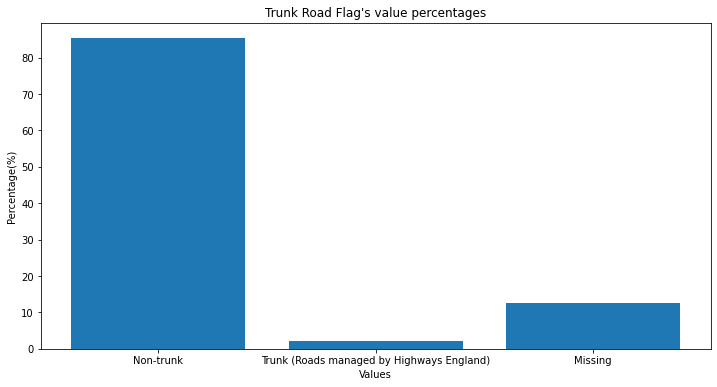

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(range(len(percentages_dictionary)), list(percentages_dictionary.values()), align='center')
plt.xticks(range(len(percentages_dictionary)), list(percentages_dictionary.keys()))
plt.title("Trunk Road Flag's value percentages")
plt.ylabel("Percentage(%)")
plt.xlabel("Values")
plt.show()

To fill in the missing values, we will check if there exists other occurences of that missing road where the trunk_road_flag was not missing. Below shows the proof that there are no inconsistencies since they were handled earlier

In [59]:
not_null_trunk = df_clean[df_clean.trunk_road_flag.notna()]
df_road = not_null_trunk.groupby(['first_road_class', 'first_road_number'])
df_road.trunk_road_flag.value_counts()

first_road_class  first_road_number                                                                                     trunk_road_flag                          
A                 100                                                                                                   Non-trunk                                       39
                  1000                                                                                                  Non-trunk                                      145
                  1003                                                                                                  Non-trunk                                       18
                  1004                                                                                                  Non-trunk                                        3
                  1005                                                                                                  Non-trunk                         

In [60]:
df_clean.trunk_road_flag.isna().mean()*100
null_trunk = df_clean[df_clean.trunk_road_flag.isna()]
not_null_trunk = df_clean[df_clean.trunk_road_flag.notna()]

def find_similar_road(road_class, road_number):
    entries_on_same_road = not_null_trunk[(not_null_trunk['first_road_class']==road_class) & (not_null_trunk['first_road_number']==road_number)]
    if(entries_on_same_road.empty):
        return "Unique"
    return entries_on_same_road.iloc[0].trunk_road_flag

df_clean['imputed_trunk']= df_clean[df_clean.trunk_road_flag.isna()].apply(lambda x: find_similar_road(x['first_road_class'], x['first_road_number']), axis=1)




As shown below 7% are marked as "Unique" which means this road with the missing trunk value is the only entry in the dataset. These missing values will be imputed using the mode which is non-trunk. The reason the mode is chosen is to keep the distribution illustrated above.

In [61]:
df_clean['imputed_trunk'].value_counts()/len(df_clean)*100

Unique                                       7.008645
Non-trunk                                    5.326141
Trunk (Roads managed by Highways England)    0.125027
Name: imputed_trunk, dtype: float64

In [62]:
df_clean.trunk_road_flag.fillna(df_clean.imputed_trunk, inplace=True)
df_clean.trunk_road_flag = df_clean.trunk_road_flag.replace('Unique', 'Non-trunk')
print("Percentage of missing values after: " ,df_clean.trunk_road_flag.isna().mean())

Percentage of missing values after:  0.0


In [63]:
df_clean = df_clean.drop('imputed_trunk', axis=1)

#### 5. Jucntion_Control, Second_Road_Class & Second_Road_Number

No junction, it doesn't make sense to impute since from the business logic it should be missing. In this case we will just fill with a default value of 0

In [64]:
df_clean.junction_control.fillna(0, inplace=True)
df_clean.second_road_class.fillna(0, inplace=True)
df_clean.second_road_number.fillna(0, inplace=True)

As illustrated below, the dataframe is now clean of any missing values

<AxesSubplot:>

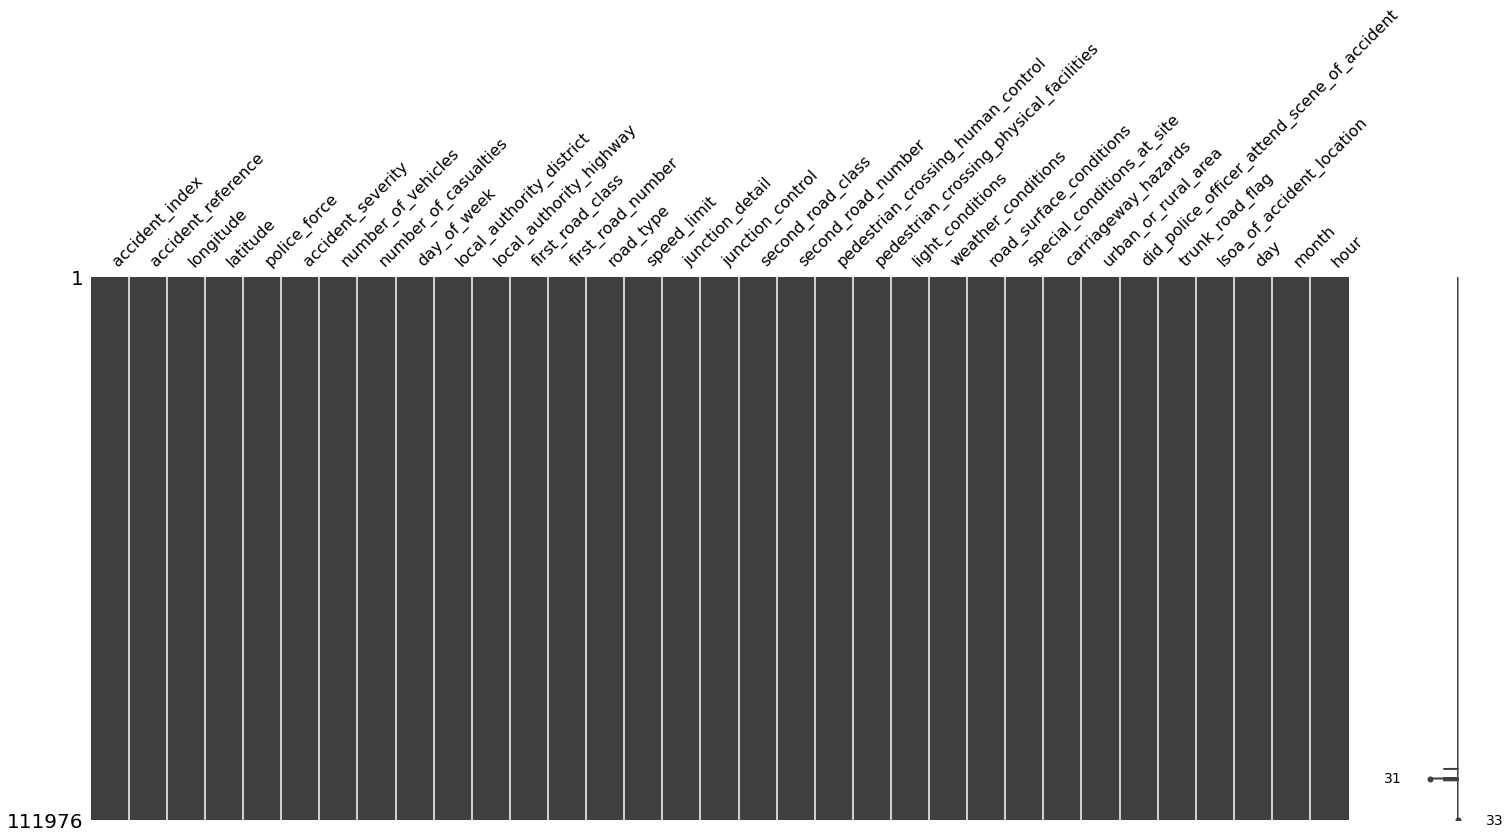

In [65]:
msno.matrix(df_clean)

### **Observing and Handling Outliers**

In [66]:
df_clean["number_of_vehicles"].skew() #High skew value indicates extreme values

1.2489658342799776

High skew value indicates the presence of outliers in column. <br/>

#### Method 1 : Z score detection

In [67]:
import scipy.stats as stats
# detection using z score (number_of_vehicles)
z = np.abs(stats.zscore(df['number_of_vehicles']))
filtered_entries = z < 3
df_zscore_filter = df[filtered_entries]
print("Total number of outliers detected are ",df.shape[0]-df_zscore_filter.shape[0]) #726 outliers detected using Z score

Total number of outliers detected are  762


#### Method 2: IQR

In [68]:
#detection using IQR (number_of_vehicles)
Q1 = df.number_of_vehicles.quantile(0.25)
Q3 = df.number_of_vehicles.quantile(0.75)
IQR = Q3 - Q1
cut_off = IQR * 1.5
lower = Q1 - cut_off
upper = Q3 + cut_off
df1 = df[df['number_of_vehicles']> upper]
df2 = df[df['number_of_vehicles'] < lower]
print('Total number of outliers are', df1.shape[0]+ df2.shape[0]) #3067

Total number of outliers are 3067


The total number of outliers detected by the Z score method (726) is less that the amount detected by the IQR (3067) and as a result Z score method will be used to handle the outliers. Median imputation was applied to outliers in this column.

In [69]:
#impute with median
median = df_clean['number_of_vehicles'].median()
df_clean['number_of_vehicles'] = df_clean['number_of_vehicles'].mask(z>3, median)
df_clean["number_of_vehicles"].skew() #now the skew is (0.58) within acceptable range

0.547409201538443

In [70]:
df_clean["number_of_casualties"].skew() #High skew value indicates extreme values

4.872602644898989

High skew value indicates the presence of outliers in column "number_of_casualties" <br/>

#### Method 1 : Z Score Detection

In [71]:
#detection using Z score (number_of_casualties)
z = np.abs(stats.zscore(df['number_of_casualties']))
filtered_entries = z < 3
df_zscore_filter = df[filtered_entries]
print("Total number of outliers detected are ", df.shape[0]-df_zscore_filter.shape[0])#3212 outliers detected using Z score

Total number of outliers detected are  3211


#### Method 2: IQR Detection


In [72]:
#detection using IQR (number_of_casualties)
Q1 = df.number_of_vehicles.quantile(0.25)
Q3 = df.number_of_vehicles.quantile(0.75)
IQR = Q3 - Q1
cut_off = IQR * 1.5
lower = Q1 - cut_off
upper = Q3 + cut_off
df1 = df[df['number_of_casualties']> upper]
df2 = df[df['number_of_casualties'] < lower]
print('Total number of outliers detected are', df1.shape[0]+ df2.shape[0]) #3211 outliers detected using IQR

Total number of outliers detected are 3211


The two outlier detection methods gave roughly the same number of outliers and hence, either can be used. Outliers in this column were imputed using median imputation


In [73]:
#impute with mean
median = df['number_of_casualties'].median()
df_clean['number_of_casualties'] = df_clean['number_of_casualties'].mask(z>3, median)
df_clean['number_of_casualties'].skew() #now the skew is (2.07) within is much acceptable

2.1737296854608097

#### Multivariate Outlier detection

##### Location (Longitude + Latitude column) outlier detection and observation using LOF

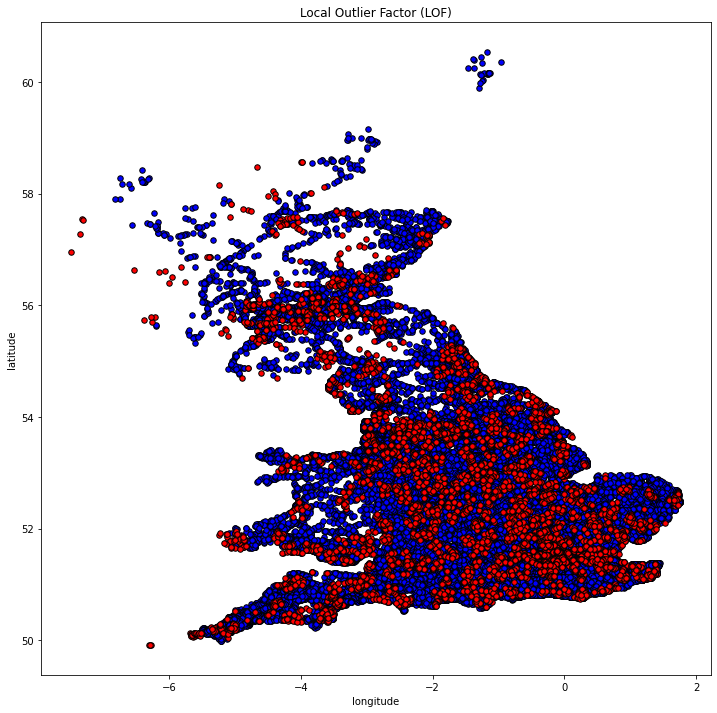

In [74]:
#detection of outliers Multivariate (longitude+latitude)
clf = LocalOutlierFactor()
X = df[['longitude','latitude']].values
y_pred = clf.fit_predict(X)

plt.figure(figsize=(12,12))
# plot the level sets of the decision function
in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('longitude');
plt.ylabel('latitude');
plt.show()


From both location outlier observations we can see that  (Longitude + Latitude) and (location_easting_osgr + location_northing_osgr) give identical information regarding the accident location and hence one pair could be disregarded

# Data Transformation

The following dataframe will be used to save all encoded data across all columns. 

In [89]:
df_transformation = df_clean.copy()
d = {'column_name': [], 'category_name': [], 'encoded_value' : [] }
df_encoded = pd.DataFrame(d)

#### 1. Urban or Rural Area Column

##### Encoding

Two unique values in column ("Urban","Rural") are label encoded to: <br/>
 1 -> "Urban" <br/>
 0 -> "Rural" <br/>

In [91]:
print(df_transformation['urban_or_rural_area'].value_counts())
df_transformation['urban_or_rural_area'] = df_transformation['urban_or_rural_area'].replace('Urban', 1)
df_transformation['urban_or_rural_area'] = df_transformation['urban_or_rural_area'].replace('Rural', 0)
df_transformation['urban_or_rural_area'].value_counts()

Urban    75598
Rural    36370
Name: urban_or_rural_area, dtype: int64


1    75598
0    36370
Name: urban_or_rural_area, dtype: int64

In [92]:
df_encoded.loc[len(df_encoded.index)] = ['urban_or_rural_area', 'Urban', 1]
df_encoded.loc[len(df_encoded.index)] = ['urban_or_rural_area', 'Rural', 0] 

#### 2. Accident Severity Column

##### Encoding

3 unique string values are present in column ("Fatal","Serious","Slight") are label encoded into <br/>
0 -> "Slight" <br/>
1 -> "Serious" <br/>
2 -> "Fatal" <br/>

In [93]:
print(df_transformation['accident_severity'].value_counts())
df_transformation['accident_severity'] = df_transformation['accident_severity'].replace('Fatal', 2)
df_transformation['accident_severity'] = df_transformation['accident_severity'].replace('Serious', 1)
df_transformation['accident_severity'] = df_transformation['accident_severity'].replace('Slight', 0)
df_transformation['accident_severity'].value_counts()


Slight     94682
Serious    16085
Fatal       1201
Name: accident_severity, dtype: int64


0    94682
1    16085
2     1201
Name: accident_severity, dtype: int64

In [84]:
df_encoded.loc[len(df_encoded.index)] = ['accident_severity', 'Fatal', 2]
df_encoded.loc[len(df_encoded.index)] = ['accident_severity', 'Serious', 1]
df_encoded.loc[len(df_encoded.index)] = ['accident_severity', 'Slight', 0]

#### 3. Junction Control

As shown junction control shows 4 distinct values. More than 68k of the entries had no control at the junction or was just merely a give way sign (red triangle with Give Way written in it). 
The other 3 values represent different types of control whether through an authorized person or a traffic signal or a stop sign. 

The zero represents no junction. Therefore the junction control at no junction will be considered as 0("controlled", for analytical purposes the data could be grouped to check if it was a junction or not.


Therefore they could simply be categorized into 2 groups Control or No Control. Therefore this column could simply be a binary column, where Give way or uncontrolled represent no control and the other categories represent control.

In [95]:
df_transformation['junction_control'] = df_transformation['junction_control'].replace('Give way or uncontrolled', 1)
df_transformation['junction_control'] = df_transformation['junction_control'].replace('Auto traffic signal', 0)
df_transformation['junction_control'] = df_transformation['junction_control'].replace('Stop sign', 0)
df_transformation['junction_control'] = df_transformation['junction_control'].replace('Authorised person', 0)
df_transformation.junction_control.value_counts()

1    57366
0    54602
Name: junction_control, dtype: int64

In [96]:
df_encoded.loc[len(df_encoded.index)] = ['junction_control', 'Give way or uncontrolled', 1]
df_encoded.loc[len(df_encoded.index)] = ['junction_control', 'Auto traffic signal', 0]
df_encoded.loc[len(df_encoded.index)] = ['junction_control', 'Stop sign', 0]
df_encoded.loc[len(df_encoded.index)] = ['junction_control', 'Authorised person', 0]

#### 4. Junction Detail

##### Discretization

As seen in the bar chart below, there are some sparse categories where there are very few total observations. To avoid overfitting the ML model and to avoid handling of categorial values that are sparse. We can group the last 5 observations into 1 observation. They all have similar types of junction , where the junction is small.
Moreover the crossroad and roundabout have similar distribution. From the business logic side they are very similar, the shape of the junction is similar, and from the statistics side they have similar contribution to accidents and therefore they could be combined into 1 category.


In [88]:
df_transformation.junction_detail.value_counts()

Not at junction or within 20 metres    43369
T or staggered junction                37646
Crossroads                             11280
Roundabout                              8879
Private drive or entrance               4644
Other junction                          2480
Mini-roundabout                         1691
Slip road                                996
More than 4 arms (not roundabout)        983
Name: junction_detail, dtype: int64

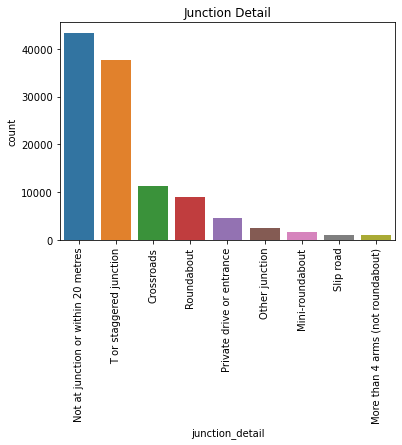

In [98]:

sns.countplot(df_transformation.junction_detail, order = df_transformation.junction_detail.value_counts().index)
plt.title('Junction Detail')
plt.xticks(rotation=90)
plt.show()

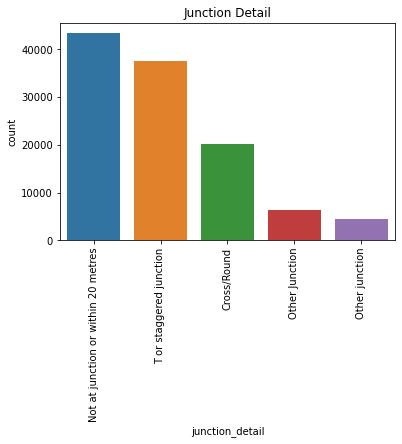

In [99]:
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('Private drive or entrance', 'Other Junction')
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('Other junction', 'Other junction')
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('Slip road', 'Other junction')
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('More than 4 arms (not roundabout)', 'Other junction')
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('Mini-roundabout', 'Other Junction')
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('Roundabout', 'Cross/Round')
df_transformation['junction_detail'] = df_transformation['junction_detail'].replace('Crossroads', 'Cross/Round')
sns.countplot(df_transformation.junction_detail, order = df_transformation.junction_detail.value_counts().index)
plt.title('Junction Detail')
plt.xticks(rotation=90)
plt.show()

##### Encoding

These 4 values could then be one hot encoded. The attributes are nominal not ordinal since there is no order between the types of junctions.

In [100]:
print("Shape before encoding: ", df_transformation.shape)
one_hot = pd.get_dummies(df_transformation.junction_detail, prefix = ['junction_'])
df_transformation = df_transformation.drop('junction_detail',axis = 1)
df_transformation = df_transformation.join(one_hot)
print("Shape after encoding: ", df_transformation.shape)


Shape before encoding:  (111968, 33)
Shape after encoding:  (111968, 37)


In [101]:
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'More than 4 arms (not roundabout)', 'Other Junction']
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'Private drive or entrance', 'Other Junction']
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'Other Junction', 'Other Junction']
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'Slip road', 'Other Junction']
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'Mini-roundabout', 'Other Junction']
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'Roundabout', 'Cross/Round']
df_encoded.loc[len(df_encoded.index)] = ['junction_detail', 'Crossroads', 'Cross/Round']

#### 5. Weather Conditions

As shown in the bar chart below, there are many categories with too much details about the weather conditions and there contribution to the whole dataset is very minimal. This is another cae of sparce categories that need to be collected together into 1 category.

In [102]:
df_transformation.weather_conditions.value_counts()

Fine no high winds       92311
Raining no high winds    12045
Other                     2014
Raining + high winds      1727
Fine + high winds         1537
Snowing no high winds     1424
Fog or mist                499
Snowing + high winds       411
Name: weather_conditions, dtype: int64

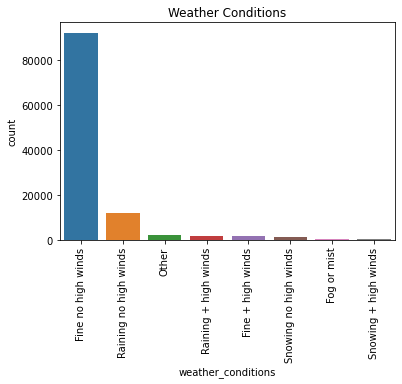

In [103]:
sns.countplot(df_transformation.weather_conditions, order = df_transformation.weather_conditions.value_counts().index)
plt.title('Weather Conditions')
plt.xticks(rotation=90)
plt.show()

Therefore, this column will include only 2 categorical values, the case where the weather is totally fine and there is no any sort of disturbances. The other case is the case where therre exists at least 1 type of disturbance in the weather, whether it is wind, rain, snow, fog, mist or any other kind of disturbance.
The bar chart below shows the distribution of the data afer converting them into 2 categories

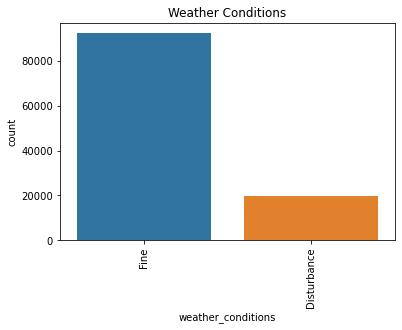

In [104]:
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Fine no high winds', 'Fine')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Raining no high winds', 'Disturbance')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Raining + high winds', 'Disturbance')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Fine + high winds', 'Disturbance')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Other', 'Disturbance')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Snowing no high winds', 'Disturbance')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Fog or mist', 'Disturbance')
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Snowing + high winds', 'Disturbance')
sns.countplot(df_transformation.weather_conditions, order = df_transformation.weather_conditions.value_counts().index)
plt.title('Weather Conditions')
plt.xticks(rotation=90)
plt.show()

Moreover, the 2 categories could then be encoded into binary.

In [105]:
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Fine', 1)
df_transformation['weather_conditions'] = df_transformation['weather_conditions'].replace('Disturbance', 0)
df_transformation['weather_conditions'].value_counts()

1    92311
0    19657
Name: weather_conditions, dtype: int64

In [106]:
df_encoded.loc[len(df_encoded.index)] = ['weather_conditions', 'Fine',1]
df_encoded.loc[len(df_encoded.index)] = ['weather_conditions', 'Disturbance', 0]

#### 6. Road Type

In [107]:
df_transformation['road_type'].value_counts()

Single carriageway    91698
Dual carriageway      10211
Roundabout             6929
One way street         2427
Slip road               703
Name: road_type, dtype: int64

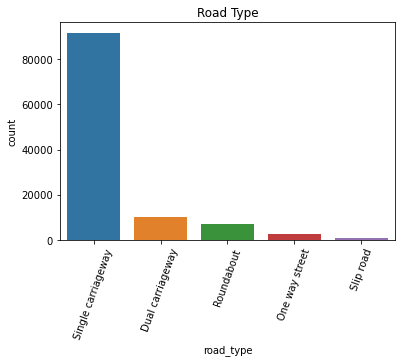

In [108]:
sns.countplot(df_transformation.road_type, order = df_transformation.road_type.value_counts().index)
plt.title('Road Type')
plt.xticks(rotation=70)
plt.show()

The 5 categories could be thought of as only 2 categories by simply asking "Is there a chance for 2 cars to be face to face?"
A single carriageway is a 2 way street with no physical divider. Is there a chance for 2 opposing cars to meet face to face? Definetly!
In dual acrriageway there is a physical divider between cars of opposing faces therefore there is no chance.
In a one way street is there a chance for 2 opposing cars to meet face to face? No. Will not have 2 opposing cars.
In a slip road is there a chance for 2 opposing cars to meet face to face? No. Will not have 2 opposing cars.
In a roundabout street, is there a chance for cars to meet face to face? Quite yes. Although not as frequent as in a single carriageway but there is a chance.

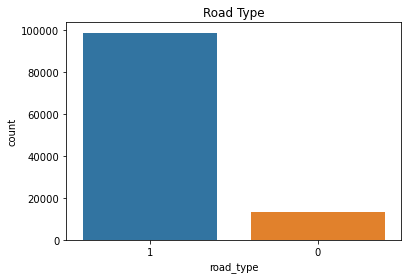

In [109]:
df_transformation['road_type'] = df_transformation['road_type'].replace('Single carriageway', 1)
df_transformation['road_type'] = df_transformation['road_type'].replace('Dual carriageway', 0)
df_transformation['road_type'] = df_transformation['road_type'].replace('One way street', 0)
df_transformation['road_type'] = df_transformation['road_type'].replace('Slip road', 0)
df_transformation['road_type'] = df_transformation['road_type'].replace('Roundabout', 1)
sns.countplot(df_transformation.road_type, order = df_transformation.road_type.value_counts().index)
plt.title('Road Type')
plt.xticks(rotation=0)
plt.show()

In [110]:
df_encoded.loc[len(df_encoded.index)] = ['road_type', 'Single carriageway', 1]
df_encoded.loc[len(df_encoded.index)] = ['road_type', 'Dual carriageway', 0]
df_encoded.loc[len(df_encoded.index)] = ['road_type', 'One way street',0]
df_encoded.loc[len(df_encoded.index)] = ['road_type', 'Slip road',0]
df_encoded.loc[len(df_encoded.index)] = ['road_type', 'Roundabout', 1]

#### 7. Road Surface Conditions

##### Discretization

As shown below, the 3 categories of "Forest or Ice", "Snow", and "Flood over 3cm deep" have very small percentages of 1.8%, 1.4% and 0.1% respectively. Using binning they could be descritized into 1 category "Extreme Conditions". The reason why we didn't choose to combine this category with "Wet or damp" is that the accident frequency for extreme conditions is almost negligible since most people usually do not drive or are very careful during extreme conditions. Combining these extreme cases with the category of "Wet or Damp" will camouflage this relation. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


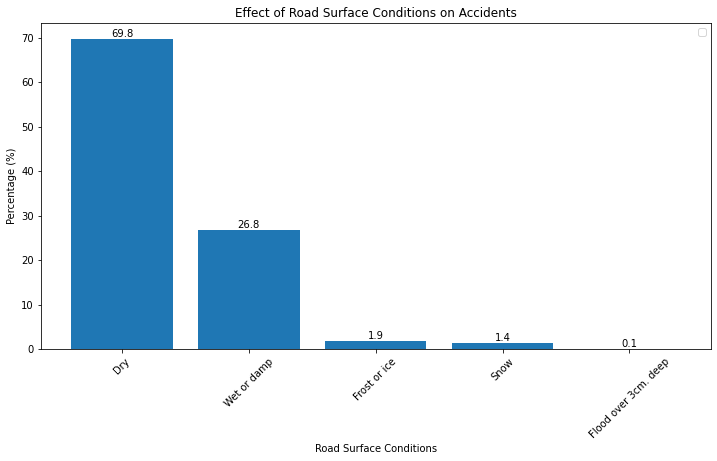

In [111]:
road_surface_percentages= round(df_transformation.road_surface_conditions.value_counts()/len(df_transformation.road_surface_conditions)*100,1)
fig, ax = plt.subplots(figsize=(12, 6))
p1 = ax.bar(road_surface_percentages.index, road_surface_percentages)
ax.set_xlabel("Road Surface Conditions")
ax.set_title('Scores by group and gender')
plt.title("Effect of Road Surface Conditions on Accidents")
plt.ylabel("Percentage (%)")
ax.set_xticklabels(road_surface_percentages.index , rotation = 45)
ax.legend()
ax.bar_label(p1, label_type='edge')
plt.show()

Shown below is the distribution of the categories after discretization. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


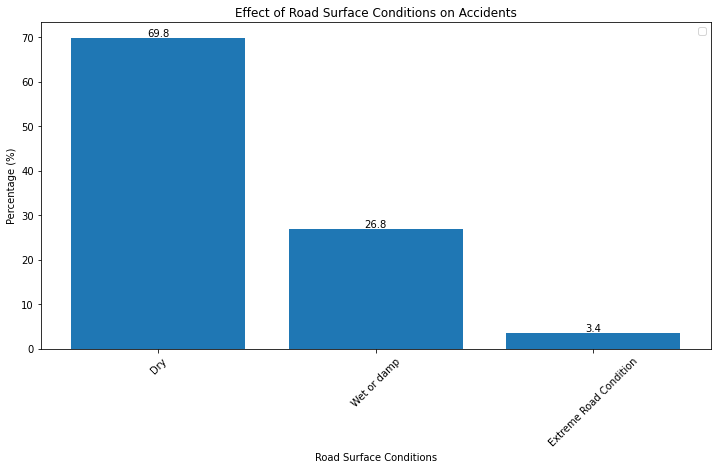

In [112]:
df_transformation['road_surface_conditions'] = df_transformation['road_surface_conditions'].replace('Frost or ice', "Extreme Road Condition")
df_transformation['road_surface_conditions'] = df_transformation['road_surface_conditions'].replace('Snow', "Extreme Road Condition")
df_transformation['road_surface_conditions'] = df_transformation['road_surface_conditions'].replace('Flood over 3cm. deep', "Extreme Road Condition")
road_surface_percentages= round(df_transformation.road_surface_conditions.value_counts()/len(df_transformation.road_surface_conditions)*100,1)
fig, ax = plt.subplots(figsize=(12, 6))
p1 = ax.bar(road_surface_percentages.index, road_surface_percentages)
ax.set_xlabel("Road Surface Conditions")
ax.set_title('Scores by group and gender')
plt.title("Effect of Road Surface Conditions on Accidents")
plt.ylabel("Percentage (%)")
ax.set_xticklabels(road_surface_percentages.index , rotation = 45)
ax.legend()
ax.bar_label(p1, label_type='edge')
plt.show()

##### Encoding

After discretization, the 3 categories show some sort of order. Dry < Wet or Damp < Extreme Conditions. The order is in increasing severity of the road conditions. Hence since the categories are ordinal then Label Encoding could be used.
Shown below is the distribution after discretization and encoding.

In [114]:
df_transformation['road_surface_conditions'] = df_transformation['road_surface_conditions'].replace('Dry', 0)
df_transformation['road_surface_conditions'] = df_transformation['road_surface_conditions'].replace('Wet or damp', 1)
df_transformation['road_surface_conditions'] = df_transformation['road_surface_conditions'].replace("Extreme Road Condition", 2)
df_transformation['road_surface_conditions'].value_counts()

0    78136
1    30063
2     3769
Name: road_surface_conditions, dtype: int64

In [115]:
df_encoded.loc[len(df_encoded.index)] = ['road_surface_conditions', 'Dry', 0]
df_encoded.loc[len(df_encoded.index)] = ['road_surface_conditions', 'Wet or damp', 1]
df_encoded.loc[len(df_encoded.index)] = ['road_surface_conditions', 'Frost or ice', 2]
df_encoded.loc[len(df_encoded.index)] = ['road_surface_conditions', 'Snow', 2]
df_encoded.loc[len(df_encoded.index)] = ['road_surface_conditions', 'Flood over 3cm. deep', 2]

#### 8. Police Force

In [116]:
df_transformation['police_force'].nunique()

51

In [117]:
df_transformation['police_force'].head()

0    Metropolitan Police
1    Metropolitan Police
2    Metropolitan Police
3    Metropolitan Police
4    Metropolitan Police
Name: police_force, dtype: object

In [154]:
le = preprocessing.LabelEncoder()
le.fit(df_transformation['police_force'])
labelEncodingMappingLAH = dict(zip(le.classes_, le.transform(le.classes_)))
df_transformation['police_force'] = le.transform(df_transformation['police_force'])
labelEncodingMappingLAH


{'Avon and Somerset': 0,
 'Bedfordshire': 1,
 'Cambridgeshire': 2,
 'Central': 3,
 'Cheshire': 4,
 'City of London': 5,
 'Cleveland': 6,
 'Cumbria': 7,
 'Derbyshire': 8,
 'Devon and Cornwall': 9,
 'Dorset': 10,
 'Dumfries and Galloway': 11,
 'Durham': 12,
 'Dyfed-Powys': 13,
 'Essex': 14,
 'Fife': 15,
 'Gloucestershire': 16,
 'Grampian': 17,
 'Greater Manchester': 18,
 'Gwent': 19,
 'Hampshire': 20,
 'Hertfordshire': 21,
 'Humberside': 22,
 'Kent': 23,
 'Lancashire': 24,
 'Leicestershire': 25,
 'Lincolnshire': 26,
 'Lothian and Borders': 27,
 'Merseyside': 28,
 'Metropolitan Police': 29,
 'Norfolk': 30,
 'North Wales': 31,
 'North Yorkshire': 32,
 'Northamptonshire': 33,
 'Northern': 34,
 'Northumbria': 35,
 'Nottinghamshire': 36,
 'South Wales': 37,
 'South Yorkshire': 38,
 'Staffordshire': 39,
 'Strathclyde': 40,
 'Suffolk': 41,
 'Surrey': 42,
 'Sussex': 43,
 'Tayside': 44,
 'Thames Valley': 45,
 'Warwickshire': 46,
 'West Mercia': 47,
 'West Midlands': 48,
 'West Yorkshire': 49,
 'W

In [155]:
# labelEncodingMappingLAH
df_transformation['police_force'].head()

0    29
1    29
2    29
3    29
4    29
Name: police_force, dtype: int64

Police has 51 distinct values, that would be too much to one-hot encode. Although they are distinct and not ordinal however we will use label encoder and the corresponding values will be present in the look-up table where the analysts who will use this dataset later on can refer to in their analysis.

In [156]:
for key in labelEncodingMappingLAH:
  df_encoded.loc[len(df_encoded.index)] = ['police_force', key,labelEncodingMappingLAH[key]]

#### 9. LSOA of accident location

In [132]:
df_transformation['lsoa_of_accident_location'].nunique()

27528

In [133]:
df_transformation['lsoa_of_accident_location'].head()

0    E01002844
1    E01002821
2    E01002878
3    E01002831
4    E01002851
Name: lsoa_of_accident_location, dtype: object

LSOA has around 28K distinct values, that would be impossible to one-hot encode. Although they are distinct and not ordinal however we will use label encoder and the corresponding values will be present in the look-up table where the analysts who will use this dataset later on can refer to in their analysis.

In [159]:
le = preprocessing.LabelEncoder()
le.fit(df_transformation['lsoa_of_accident_location'])
labelEncodingMappingLAH = dict(zip(le.classes_, le.transform(le.classes_)))
df_transformation['lsoa_of_accident_location'] = le.transform(df_transformation['lsoa_of_accident_location'])
labelEncodingMappingLAH


{'E01000001': 0,
 'E01000002': 1,
 'E01000005': 2,
 'E01000006': 3,
 'E01000007': 4,
 'E01000008': 5,
 'E01000009': 6,
 'E01000010': 7,
 'E01000011': 8,
 'E01000012': 9,
 'E01000013': 10,
 'E01000016': 11,
 'E01000017': 12,
 'E01000021': 13,
 'E01000022': 14,
 'E01000023': 15,
 'E01000024': 16,
 'E01000025': 17,
 'E01000027': 18,
 'E01000029': 19,
 'E01000030': 20,
 'E01000031': 21,
 'E01000032': 22,
 'E01000034': 23,
 'E01000035': 24,
 'E01000036': 25,
 'E01000037': 26,
 'E01000038': 27,
 'E01000039': 28,
 'E01000042': 29,
 'E01000043': 30,
 'E01000045': 31,
 'E01000049': 32,
 'E01000050': 33,
 'E01000052': 34,
 'E01000053': 35,
 'E01000054': 36,
 'E01000055': 37,
 'E01000056': 38,
 'E01000057': 39,
 'E01000058': 40,
 'E01000060': 41,
 'E01000061': 42,
 'E01000062': 43,
 'E01000063': 44,
 'E01000064': 45,
 'E01000065': 46,
 'E01000066': 47,
 'E01000067': 48,
 'E01000068': 49,
 'E01000069': 50,
 'E01000070': 51,
 'E01000071': 52,
 'E01000072': 53,
 'E01000073': 54,
 'E01000074': 55,
 '

In [160]:
for key in labelEncodingMappingLAH:
  df_encoded.loc[len(df_encoded.index)] = ['lsoa_of_accident_location', key,labelEncodingMappingLAH[key]]

In [161]:
# df_transformed['lsoa_of_accident_location'] = df_clean['lsoa_of_accident_location'] 
df_transformation['lsoa_of_accident_location'].head()

0    2258
1    2236
2    2289
3    2245
4    2265
Name: lsoa_of_accident_location, dtype: int64

#### 10. Road Classes

Road class could be one-hot encoded. First label-encoding will not be preferred since the number of distinct values is not big and the values are ordinal. Binary encoding could represent the data with less features than one hot encoing however one hot encoding will be used for the road classes for 2 reasons. First because the number of distinct values is relatively okay. Second because the road class might be correlated to other attributes and highly correlated to the frequency of accidents. One-hot encoding in this case will be useful to highlight the correlation of it's values since the road class type on its own may not be correlated. This will be useful for analysis

In [166]:
df_transformation.first_road_class.value_counts()

A               42152
Unclassified    37904
B               17435
C               11752
Motorway         2333
A(M)              392
Name: first_road_class, dtype: int64

In [165]:
print("Dataframe shape before encoding: ", df_transformation.shape)
new_categorical_subset= pd.get_dummies(df_transformation.first_road_class,drop_first=True)
print(new_categorical_subset)
df_transformation = pd.concat([df_transformation, new_categorical_subset], axis=1)
print("Shape after encoding :" ,df_transformation.shape)

Dataframe shape before encoding:  (111968, 37)
        A(M)  B  C  Motorway  Unclassified
0          0  0  0         0             0
1          0  0  0         0             0
2          0  1  0         0             0
3          0  1  0         0             0
4          0  0  0         0             0
...      ... .. ..       ...           ...
138655     0  0  0         0             0
138656     0  0  0         0             1
138657     0  0  0         0             0
138658     0  0  1         0             0
138659     1  0  0         0             0

[111968 rows x 5 columns]
Shape after encoding : (111968, 42)


In [167]:
df_transformation = df_transformation.drop('first_road_class', axis=1)
print("Shape after dropping :" ,df_transformation.shape)


Shape after dropping : (111968, 41)


Since second road class has 40% missing values when accidents did not occur at junction, therefore it will not be one hot encoded. We will label encode the values.

In [150]:
df_transformation['second_road_class'] = np.where(df_transformation['second_road_class'] ==0, "No second road", df_transformation['second_road_class'])
le = preprocessing.LabelEncoder()
le.fit(df_transformation['second_road_class'])
labelEncodingMappingLAH = dict(zip(le.classes_, le.transform(le.classes_)))
df_transformation['second_road_class'] = le.transform(df_transformation['second_road_class'])
labelEncodingMappingLAH


{'A': 0,
 'A(M)': 1,
 'B': 2,
 'C': 3,
 'Motorway': 4,
 'No second road': 5,
 'Unclassified': 6}

In [151]:
df_transformation.second_road_class.value_counts()
df_transformation['second_road_class']

0         6
1         0
2         2
3         3
4         6
         ..
138655    2
138656    6
138657    6
138658    6
138659    5
Name: second_road_class, Length: 111968, dtype: int64

#### 11. Carriageway Hazards

##### 1. Descretization

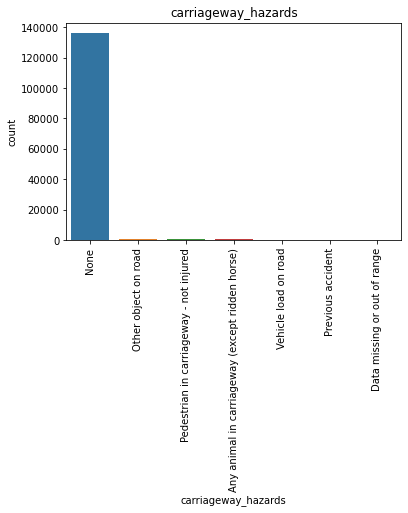

In [ ]:
sns.countplot('carriageway_hazards', data =df )
plt.title('carriageway_hazards')
plt.xticks(rotation=90)
plt.show()

By observing the categorical attribute, most of the data values lie in the "None" category while only 1.7% of the data have one of the rest hazard category types combined. As a result, this category was discretized into two groups ("yes","no") values based on whether a hazard exists or not. These two values are then encoded using label encoding 0->"No" 1->"yes"

##### 2. Encoding

In [168]:
df_transformation['carriageway_hazards'] = df_transformation['carriageway_hazards'].replace('None', 0)
df_transformation['carriageway_hazards'] = df_transformation['carriageway_hazards'].replace('Other object on road', 1)
df_transformation['carriageway_hazards'] = df_transformation['carriageway_hazards'].replace('Any animal in carriageway (except ridden horse)', 1)
df_transformation['carriageway_hazards'] = df_transformation['carriageway_hazards'].replace('Pedestrian in carriageway - not injured', 1)
df_transformation['carriageway_hazards'] = df_transformation['carriageway_hazards'].replace('Previous accident', 1)
df_transformation['carriageway_hazards'] = df_transformation['carriageway_hazards'].replace('Vehicle load on road', 1)
print("New column value counts")
print(df_transformation["carriageway_hazards"].value_counts())

New column value counts
0    110047
1      1921
Name: carriageway_hazards, dtype: int64


By observing the categorical attribute, most of the data values lie in the "None" category while only 1.7% of the data have one of the rest hazard category types combined. As a result, this category was discretized into two groups ("yes","no") values based on whether a hazard exists or not. These two values are then encoded using label encoding 0->"No" 1->"yes"

In [169]:
df_encoded.loc[len(df_encoded.index)] = ['carriageway_hazards', 'None', 0]
df_encoded.loc[len(df_encoded.index)] = ['carriageway_hazards', 'Other object on road', 1]
df_encoded.loc[len(df_encoded.index)] = ['carriageway_hazards', 'Any animal in carriageway (except ridden horse)', 1]
df_encoded.loc[len(df_encoded.index)] = ['carriageway_hazards', 'Pedestrian in carriageway - not injured', 1]
df_encoded.loc[len(df_encoded.index)] = ['carriageway_hazards', 'Vehicle load on road', 1]
df_encoded.loc[len(df_encoded.index)] = ['carriageway_hazards', 'Data missing or out of range', 1]

#### 12. Special conditions at site

##### 1. Decretization

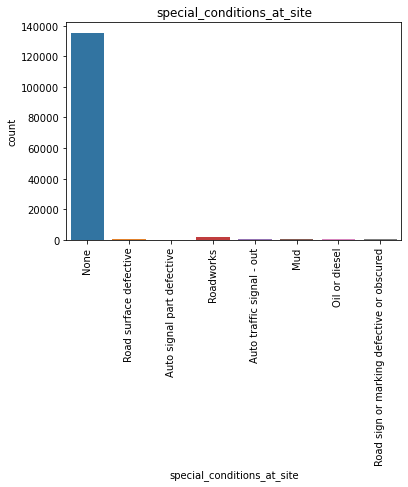

In [ ]:
sns.countplot('special_conditions_at_site', data =df )
plt.title('special_conditions_at_site')
plt.xticks(rotation=90)
plt.show()

By observing the categorical attribute, most of the data values lie in the "None" category while only 2.8% of the data have one of the rest hazard category types combined. As a result, this category was discretized into two groups ("yes","No") values based on whether a special condition exists or not. These two values are then encoded using label encoding 0->"No" 1->"yes"

##### 2. Encoding

In [170]:
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('None', 0)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Roadworks', 1)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Mud', 1)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Oil or diesel', 1)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Road surface defective', 1)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Auto signal part defective', 1)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Auto traffic signal - out', 1)
df_transformation['special_conditions_at_site'] = df_transformation['special_conditions_at_site'].replace('Road sign or marking defective or obscured', 1)
print("New Column values")
print(df_transformation["special_conditions_at_site"].value_counts())

New Column values
0    109483
1      2485
Name: special_conditions_at_site, dtype: int64


In [171]:
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'None', 0]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Roadworks', 1]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Mud', 1]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Oil or diesel', 1]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Road surface defective', 1]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Auto signal part defective', 1]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Auto traffic signal - out', 1]
df_encoded.loc[len(df_encoded.index)] = ['special_conditions_at_site', 'Road sign or marking defective or obscured', 1]

#### 13. Pedestrian cCrossing Human Control

##### 1. Descretization

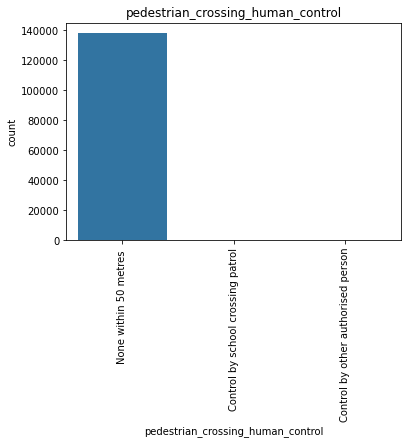

In [ ]:
sns.countplot('pedestrian_crossing_human_control', data =df )
plt.title('pedestrian_crossing_human_control')
plt.xticks(rotation=90)
plt.show()

By observing the categorical attribute, most of the data values lie in the "None within 50 metres" category while only 0.48% of the data have one of the rest category types combined. As a result, this category was discretized into two groups ("yes","no") values based on whether a pedestrian crossing human control was present or not. These two values are then encoded using label encoding 0->"No" 1->"yes"

##### 2. Encoding

In [172]:
df_transformation['pedestrian_crossing_human_control'] = df_transformation['pedestrian_crossing_human_control'].replace('None within 50 metres ', 0)
df_transformation['pedestrian_crossing_human_control'] = df_transformation['pedestrian_crossing_human_control'].replace('Control by school crossing patrol', 1)
df_transformation['pedestrian_crossing_human_control'] = df_transformation['pedestrian_crossing_human_control'].replace('Control by other authorised person', 1)
print(df_clean['pedestrian_crossing_human_control'].value_counts())

None within 50 metres                 111384
Control by school crossing patrol        304
Control by other authorised person       280
Name: pedestrian_crossing_human_control, dtype: int64


In [173]:
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_human_control', 'None within 50 metres', 0]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_human_control', 'Control by school crossing patrol', 1]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_human_control', 'Control by other authorised person', 1]

#### 14. Pedestrian Crossing Physical Facilities

##### 1. Descretization 

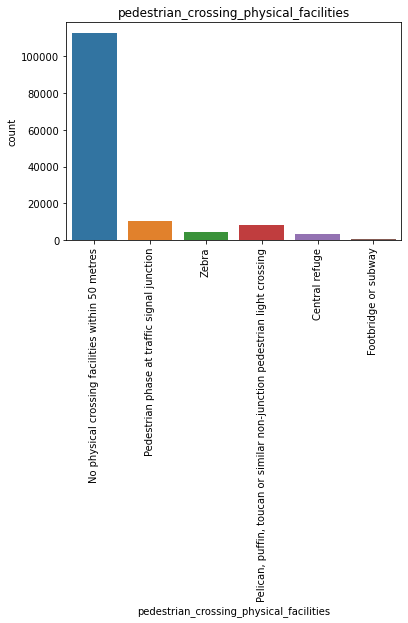

In [ ]:
sns.countplot('pedestrian_crossing_physical_facilities', data =df )
plt.title('pedestrian_crossing_physical_facilities')
plt.xticks(rotation=90)
plt.show()

By observation, most of the column values are "No physical crossing facilities within 50 metres". As a result all the other possible values can be grouped into one value. The product of the resulting descretization is: <br/>
1. "No physical crossing facilities within 50 metres" <br/>
2. "Faculty exists" <br/>

These values are then later encoded using label encoding into: <br/>
0 -> "No physical crossing facilities within 50 metres" <br/>
1 -> "Faculty exists" <br/>

##### 2. Label Encoding

In [174]:

print("New column values")
df_transformation['pedestrian_crossing_physical_facilities'] = df_transformation['pedestrian_crossing_physical_facilities'].replace('No physical crossing facilities within 50 metres', 0)
df_transformation['pedestrian_crossing_physical_facilities'] = df_transformation['pedestrian_crossing_physical_facilities'].replace('Pedestrian phase at traffic signal junction', 1)
df_transformation['pedestrian_crossing_physical_facilities'] = df_transformation['pedestrian_crossing_physical_facilities'].replace('Pelican, puffin, toucan or similar non-junction pedestrian light crossing', 1)
df_transformation['pedestrian_crossing_physical_facilities'] = df_transformation['pedestrian_crossing_physical_facilities'].replace('Zebra', 1)
df_transformation['pedestrian_crossing_physical_facilities'] = df_transformation['pedestrian_crossing_physical_facilities'].replace('Central refuge', 1)
df_transformation['pedestrian_crossing_physical_facilities'] = df_transformation['pedestrian_crossing_physical_facilities'].replace('Footbridge or subway', 1)
print(df_transformation['pedestrian_crossing_physical_facilities'].value_counts())

New column values
0    91591
1    20377
Name: pedestrian_crossing_physical_facilities, dtype: int64


In [175]:
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_physical_facilities', 'No physical crossing facilities within 50 metres', 0]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_physical_facilities', 'Pedestrian phase at traffic signal junction', 1]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_physical_facilities', 'Pelican, puffin, toucan or similar non-junction pedestrian light crossing', 1]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_physical_facilities', 'Zebra', 1]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_physical_facilities', 'Central refuge', 1]
df_encoded.loc[len(df_encoded.index)] = ['pedestrian_crossing_physical_facilities', 'Footbridge or subway', 1]

#### 15. Light Conditions

##### 1. Descretization

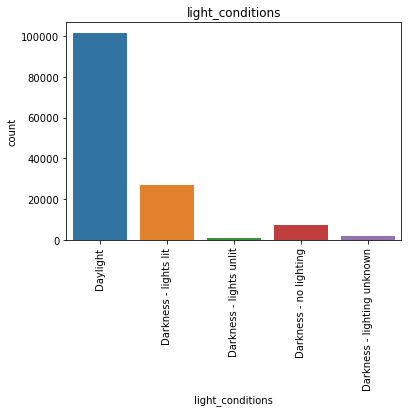

In [ ]:
sns.countplot('light_conditions', data =df )
plt.title('light_conditions')
plt.xticks(rotation=90)
plt.show()

By observing the values, most of the values lie in the "Daylight" category. we can perforn desretization by grouping "Darkness-lights unlit" and "Darkness-no lighting" and grouping "Darkness-lights lit" and "Darkness-lights unknown". The resulting categorical attribute values are: <br/>
1. "Daylight" <br/>
2. "Darkness with lights" <br/>
3. "Darkness without lights" <br/>
These values are later encoded using label encoding giving valumns values: <br/>
1. 0 -> "Daylight" <br/>
2. 1 -> "Darkness with lights" <br/>
3. 2 -> "Darkness without lights" <br/>


##### 2. Encoding

In [176]:
df_transformation['light_conditions'] = df_transformation['light_conditions'].replace('Daylight', 0)
df_transformation['light_conditions'] = df_transformation['light_conditions'].replace('Darkness - lights lit', 1)
df_transformation['light_conditions'] = df_transformation['light_conditions'].replace('Darkness - no lighting', 2)
df_transformation['light_conditions'] = df_transformation['light_conditions'].replace('Darkness - lighting unknown', 1)
df_transformation['light_conditions'] = df_transformation['light_conditions'].replace('Darkness - lights unlit', 2)
print(df_transformation['light_conditions'].value_counts())

0    82497
1    23236
2     6235
Name: light_conditions, dtype: int64


In [177]:
df_encoded.loc[len(df_encoded.index)] = ['light_conditions', 'Daylight', 0]
df_encoded.loc[len(df_encoded.index)] = ['light_conditions', 'Darkness - lights lit', 1]
df_encoded.loc[len(df_encoded.index)] = ['light_conditions', 'Darkness - no lighting', 2]
df_encoded.loc[len(df_encoded.index)] = ['light_conditions', 'Darkness - lighting unknown', 1]
df_encoded.loc[len(df_encoded.index)] = ['light_conditions', 'Darkness - lights unlit', 2]

#### 16. did_police_officer_attend_scene_of_accident

##### Encoding

In [178]:
print(df_transformation["did_police_officer_attend_scene_of_accident"].value_counts())

Yes    91646
No     20322
Name: did_police_officer_attend_scene_of_accident, dtype: int64


The two unique values in the column are encoded using label encoding as: <br/>
0-> no </br>
1->yes </br>

In [345]:
df_transformation['did_police_officer_attend_scene_of_accident'] = df_transformation['did_police_officer_attend_scene_of_accident'].replace('No', 0)
df_transformation['did_police_officer_attend_scene_of_accident'] = df_transformation['did_police_officer_attend_scene_of_accident'].replace('Yes', 1)
print(df_transformation["did_police_officer_attend_scene_of_accident"].value_counts())

1    91646
0    20322
Name: did_police_officer_attend_scene_of_accident, dtype: int64


In [180]:
df_encoded.loc[len(df_encoded.index)] = ['did_police_officer_attend_scene_of_accident', 'Yes', 0]
df_encoded.loc[len(df_encoded.index)] = ['did_police_officer_attend_scene_of_accident', 'No', 1]

#### 17. Local Authority District

##### Encoding

Below shows the entries in the column local authority district before encoding. Again label encoding was chosen due to the high cardinality and although it is not ordinal but the corresponding values ill be available in the look-up table fore the analysts to refer to.

In [181]:
df_transformation['local_authority_district']

0         Kensington and Chelsea
1         Kensington and Chelsea
2         Kensington and Chelsea
3         Kensington and Chelsea
4         Kensington and Chelsea
                   ...          
138655     Dumfries and Galloway
138656     Dumfries and Galloway
138657     Dumfries and Galloway
138658     Dumfries and Galloway
138659     Dumfries and Galloway
Name: local_authority_district, Length: 111968, dtype: object

This attribute contains 380 unique strings which are encoded using label encoding

In [182]:
le = preprocessing.LabelEncoder()
le.fit(df_transformation['local_authority_district'])
labelEncodingMappingLAH = dict(zip(le.classes_, le.transform(le.classes_)))
df_transformation['local_authority_district'] = le.transform(df_transformation['local_authority_district'])
labelEncodingMappingLAH


{'Aberdeen City': 0,
 'Aberdeenshire': 1,
 'Adur': 2,
 'Allerdale': 3,
 'Amber Valley': 4,
 'Angus': 5,
 'Argyll and Bute': 6,
 'Arun': 7,
 'Ashfield': 8,
 'Ashford': 9,
 'Aylesbury Vale': 10,
 'Babergh': 11,
 'Barking and Dagenham': 12,
 'Barnet': 13,
 'Barnsley': 14,
 'Barrow-in-Furness': 15,
 'Basildon': 16,
 'Basingstoke and Deane': 17,
 'Bassetlaw': 18,
 'Bath and North East Somerset': 19,
 'Bedford': 20,
 'Bexley': 21,
 'Birmingham': 22,
 'Blaby': 23,
 'Blackburn with Darwen': 24,
 'Blackpool': 25,
 'Blaenau Gwent': 26,
 'Bolsover': 27,
 'Bolton': 28,
 'Boston': 29,
 'Bournemouth': 30,
 'Bracknell Forest': 31,
 'Bradford': 32,
 'Braintree': 33,
 'Breckland': 34,
 'Brent': 35,
 'Brentwood': 36,
 'Bridgend': 37,
 'Brighton and Hove': 38,
 'Bristol, City of': 39,
 'Broadland': 40,
 'Bromley': 41,
 'Bromsgrove': 42,
 'Broxbourne': 43,
 'Broxtowe': 44,
 'Burnley': 45,
 'Bury': 46,
 'Caerphilly': 47,
 'Calderdale': 48,
 'Cambridge': 49,
 'Camden': 50,
 'Cannock Chase': 51,
 'Canterbury

In [183]:
for key in labelEncodingMappingLAH:
    df_encoded.loc[len(df_encoded.index)] = ['local_authority_district', key,labelEncodingMappingLAH[key]]

In [184]:
df_transformation['local_authority_district'].head()

0    166
1    166
2    166
3    166
4    166
Name: local_authority_district, dtype: int64

#### 18. Trunk Road Flag

Two unique values ("Non-trunk","Trunk (Roads managed by Highways England)") will be encoded to 1 and 0 as shown below: 

In [185]:
df_transformation['trunk_road_flag'] .value_counts()

Non-trunk                                    109378
Trunk (Roads managed by Highways England)      2590
Name: trunk_road_flag, dtype: int64

In [188]:
print(df_transformation['trunk_road_flag'].value_counts())
df_transformation['trunk_road_flag'] = df_transformation['trunk_road_flag'].replace('Non-trunk', 0)
df_transformation['trunk_road_flag'] = df_transformation['trunk_road_flag'].replace('Trunk (Roads managed by Highways England)', 1)
print(df_transformation['trunk_road_flag'].value_counts())


Non-trunk                                    109378
Trunk (Roads managed by Highways England)      2590
Name: trunk_road_flag, dtype: int64
0    109378
1      2590
Name: trunk_road_flag, dtype: int64


In [190]:
df_encoded.loc[len(df_encoded.index)] = ['trunk_road_flag', 'Non-trunk', 0]
df_encoded.loc[len(df_encoded.index)] = ['trunk_road_flag', 'Trunk (Roads managed by Highways England)', 1] 


#### 19. Local Authority Highway

1. Encoding

In [191]:
df_transformation['local_authority_highway'].nunique()

207

In [192]:
df_transformation['local_authority_highway'].head()

0    Kensington and Chelsea
1    Kensington and Chelsea
2    Kensington and Chelsea
3    Kensington and Chelsea
4    Kensington and Chelsea
Name: local_authority_highway, dtype: object

Since we need to have all data in numbere, we should encode this column. After observing this column, we found that there are 208 unique values so one hot encoding won't be the best solution in this case. So, label encoding is the best approach in this case

In [193]:
le = preprocessing.LabelEncoder()
le.fit(df_transformation['local_authority_highway'])
labelEncodingMappingLAH = dict(zip(le.classes_, le.transform(le.classes_)))
df_transformation['local_authority_highway'] = le.transform(df_transformation['local_authority_highway'])
labelEncodingMappingLAH


{'Aberdeen City': 0,
 'Aberdeenshire': 1,
 'Angus': 2,
 'Argyll & Bute': 3,
 'Barking and Dagenham': 4,
 'Barnet': 5,
 'Barnsley': 6,
 'Bath and North East Somerset': 7,
 'Bedford': 8,
 'Bexley': 9,
 'Birmingham': 10,
 'Blackburn with Darwen': 11,
 'Blackpool': 12,
 'Blaenau Gwent': 13,
 'Bolton': 14,
 'Bournemouth': 15,
 'Bracknell Forest': 16,
 'Bradford': 17,
 'Brent': 18,
 'Bridgend': 19,
 'Brighton and Hove': 20,
 'Bristol, City of': 21,
 'Bromley': 22,
 'Buckinghamshire': 23,
 'Bury': 24,
 'Caerphilly': 25,
 'Calderdale': 26,
 'Cambridgeshire': 27,
 'Camden': 28,
 'Cardiff': 29,
 'Carmarthenshire': 30,
 'Central Bedfordshire': 31,
 'Ceredigion': 32,
 'Cheshire East': 33,
 'Cheshire West and Chester': 34,
 'City of London': 35,
 'Clackmannanshire': 36,
 'Conwy': 37,
 'Cornwall': 38,
 'County Durham': 39,
 'Coventry': 40,
 'Croydon': 41,
 'Cumbria': 42,
 'Darlington': 43,
 'Denbighshire': 44,
 'Derby': 45,
 'Derbyshire': 46,
 'Devon': 47,
 'Doncaster': 48,
 'Dorset': 49,
 'Dudley':

In [194]:
## replacing the values of local_authority_highway to the encoded values
for key in labelEncodingMappingLAH:
  df_transformation['local_authority_highway'] = df_transformation['local_authority_highway'].replace(key,labelEncodingMappingLAH[key])

In [195]:
df_transformation['local_authority_highway'].head()

0    89
1    89
2    89
3    89
4    89
Name: local_authority_highway, dtype: int64

In [483]:
## adding the values of local_authority_highway and its corresponding encoded values in df_encoded
for key in labelEncodingMappingLAH:
    df_encoded.loc[len(df_encoded.index)] = ['local_authority_highway', key,labelEncodingMappingLAH[key]]

#### 20. Day of Week

In [346]:
df_transformation['day_of_week'].value_counts()

Friday       17456
Tuesday      16975
Thursday     16853
Wednesday    16183
Monday       15615
Saturday     15343
Sunday       13514
Name: day_of_week, dtype: int64

In [347]:
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Monday", 0)
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Sunday", 1)
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Tuesday", 2)
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Wednesday", 3)
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Thursday", 4)
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Friday", 5)
df_transformation['day_of_week'] = df_transformation['day_of_week'].replace("Saturday", 6)


In [348]:
df_transformation['day_of_week'].value_counts()

5    17456
2    16975
4    16853
3    16183
0    15615
6    15343
1    13514
Name: day_of_week, dtype: int64

#### 21. First Road Number

In [349]:
df_transformation['first_road_number'].value_counts()

first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero     49639
25                                                                                                        784
406                                                                                                       411
24                                                                                                        410
205                                                                                                       325
                                                                                                        ...  
1212                                                                                                        1
1392                                                                                                        1
1216                                                                                                        1
1247      

In [352]:
df_transformation['first_road_number'] = df['first_road_number'].replace("first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero ", 0)

In [353]:
df_transformation['first_road_number'].value_counts()

0       49639
25        784
406       411
24        410
205       325
        ...  
1212        1
1392        1
1216        1
1247        1
4153        1
Name: first_road_number, Length: 3211, dtype: int64

#### 22. Second Road Number

In [354]:
df_transformation['second_road_number'].value_counts()

first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero     53149
0                                                                                                       44383
1.0                                                                                                       118
4.0                                                                                                       114
40.0                                                                                                       98
                                                                                                        ...  
6857.0                                                                                                      1
2188.0                                                                                                      1
6192.0                                                                                                      1
6048.0    

In [358]:
df_transformation['second_road_number'] = df_transformation['second_road_number'].replace("first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero ", 0)
df_transformation['second_road_number'] = df_transformation['second_road_number'].replace("0", 0)

In [359]:
df_transformation['second_road_number'].value_counts()

0         97532
1.0         118
4.0         114
40.0         98
406.0        89
          ...  
6857.0        1
2188.0        1
6192.0        1
6048.0        1
2144.0        1
Name: second_road_number, Length: 2381, dtype: int64

In [386]:
final_df.first_road_number = final_df.first_road_number.astype(int)
final_df.second_road_number = final_df.second_road_number.astype(float)

### Transformation by Normalization of Nummerical Attributes



The only column that we will normalize is the speed limit column. Longitue & LAtitude are numerical columns however they could be thought of as discrete values and not continuous. Same argument goes for the number of vehicles and number of casualties. Normalization involves changing the shape of the distribution of your data, in this case we do not wish to change the distribution of the number of vehicles and number of casualties, the distribution should remain the same for analysis purposes. Therefore the numericaln attribute speed limit will be scaled, this attribute could be perceived as continuous, the range of the speed could be very high. Therefore it should be scaled before feeding these data to any ML models to avoid favoring of one feature over the other; also it will make the algorithm converge faster since gradient descent algorithms converge faster and perform better on scaled data.

##### Attribute: Speed Limit



Speed limit attribute is normalized as it is continuous.

In [196]:
print(df_transformation[["speed_limit"]].describe)
df_transformation[["speed_limit"]]= MinMaxScaler().fit_transform(df_transformation[["speed_limit"]])
print(df_transformation[["speed_limit"]].describe)

<bound method NDFrame.describe of         speed_limit
0              30.0
1              30.0
2              30.0
3              30.0
4              30.0
...             ...
138655         60.0
138656         30.0
138657         30.0
138658         60.0
138659         70.0

[111968 rows x 1 columns]>
<bound method NDFrame.describe of         speed_limit
0               0.2
1               0.2
2               0.2
3               0.2
4               0.2
...             ...
138655          0.8
138656          0.2
138657          0.2
138658          0.8
138659          1.0

[111968 rows x 1 columns]>


# Saving Dataframe

In [ ]:
df_transformation.to_csv("final_df_1.csv")

## Use all Diagnostics techniques to compare between the performance of ALL the following classifiers: KNN / Naive Bayes / Logistic Regression / Neural Networks

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import cross_val_score
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
# Ignore specific warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [3]:
# Load the dataset
df_new= pd.read_csv("final_df_1.csv")
#The code you provided splits the data into 80% training data and 20% test data. This is a common practice in machine learning, and it helps to ensure that the model is not overfitting the training data.
x_train = df_new.iloc[:, :-1]
y_train = df_new.iloc[:, -1]
x_test = df_new.iloc[-100:, :-1]
y_test = df_new.iloc[-100:, -1]

In [5]:
# Train the classifiers using training set

#KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

#Naive-Bayes
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)

#Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

#Neural Networks
nn = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', learning_rate='adaptive', max_iter=1000)
nn.fit(x_train, y_train)
y_pred_nn = nn.predict(x_test)

In [6]:
# Evaluate the classifiers using testing set
print('KNN accuracy:', knn.score(x_test, y_test))
print('Naive Bayes accuracy:', nb.score(x_test, y_test))
print('Logistic Regression accuracy:', lr.score(x_test, y_test))
print('Neural Network accuracy:', nn.score(x_test, y_test))

KNN accuracy: 0.31
Naive Bayes accuracy: 0.47
Logistic Regression accuracy: 0.26
Neural Network accuracy: 0.05


The neural network has the worst accuracy because it is a more complex model than the other classifiers. This means that it is more likely to overfit the training data, and to perform poorly on the test data.

In [7]:
# Calculating the confusion matrices for each classifier 
cm_knn = confusion_matrix(y_test, knn.predict(x_test))
print("K-Nearest Neighbors Classifier:")
print(cm_knn)

cm_nb = confusion_matrix(y_test, nb.predict(x_test))
print("\nNaive Bayes Classifier:")
print(cm_nb)


cm_lr = confusion_matrix(y_test, lr.predict(x_test))
print("\nLogistic Regression Classifier:")
print(cm_lr)

cm_nn = confusion_matrix(y_test, nn.predict(x_test))
print("\nNeural Network Classifier:")
print(confusion_matrix(y_test, y_pred_nn))



K-Nearest Neighbors Classifier:
[[3 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]]

Naive Bayes Classifier:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]

Logistic Regression Classifier:
[[0 0 0 ... 0 0 3]
 [0 0 1 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 0]]

Neural Network Classifier:
[[0 0 0 ... 0 0 3]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 4]
 ...
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 2]
 [0 0 0 ... 0 0 5]]


The confusion matrices for the classifiers show that they are not very good at classifying the data.

The KNN classifier has a high number of false negatives, which means that it is more likely to classify a positive instance as negative. This can be a problem if the classifier is being used to make decisions that have consequences. In the confusion matrix, the false negatives are shown in the bottom left corner.
The Naive Bayes classifier has a high number of both false positives and false negatives. This means that it is not very good at classifying the data at all. In the confusion matrix, the false positives are shown in the top right corner.The false negatives are shown in the bottom left corner.
The Logistic Regression classifier has the best results of the four classifiers, but it still has a high number of false positives. In the confusion matrix, the false positives are shown in the top right corner.

First, the neural network has the lowest accuracy of all the classifiers, which means that it is not as good at classifying the data as the other classifiers. This is likely due to the fact that the neural network is a more complex model, and is more likely to overfit the training data.
Second, the neural network has a high number of false positives. This means that the neural network is more likely to classify a negative instance as positive. This can be a problem if the classifier is being used to make decisions that have consequences, such as classifying whether or not someone has a disease.
Third, the neural network has a low number of true positives. This means that the neural network is less likely to classify a positive instance as positive. This can also be a problem if the classifier is being used to make decisions that have consequences.

In [8]:
# Calculating Cross-validation Scores and Mean Accuracy for each classfier 
print("\nK-Nearest Neighbors Classifier:")
scores_knn = cross_val_score(knn, x_train, y_train, cv=5)
print(scores_knn)
print("Mean Accuracy: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))

print("\nNaive Bayes Classifier:")
scores_nb = cross_val_score(nb, x_train, y_train, cv=5)
print(scores_nb)
print("Mean Accuracy: %0.2f (+/- %0.2f)" % (scores_nb.mean(), scores_nb.std() * 2))
                                            
                                        
print("\nLogistic Regression Classifier:")
scores_lr = cross_val_score(lr, x_train, y_train, cv=5)
print(scores_lr)
print("Mean Accuracy: %0.2f (+/- %0.2f)" % (scores_lr.mean(), scores_lr.std() * 2))
                                            
                                            
print("\nNeural Network Classifier:")
scores_nn = cross_val_score(nn, x_train, y_train, cv=5)
print(scores_nn)
print("Mean Accuracy: %0.2f (+/- %0.2f)" % (scores_nn.mean(), scores_nn.std() * 2))


K-Nearest Neighbors Classifier:
[0.01788981 0.01312266 0.0152699  0.02291508 0.01635974]
Mean Accuracy: 0.02 (+/- 0.01)

Naive Bayes Classifier:
[0.57907651 0.51602392 0.50837166 0.55157011 0.59274987]
Mean Accuracy: 0.55 (+/- 0.07)

Logistic Regression Classifier:
[0.26874861 0.33694876 0.36696879 0.31433421 0.34413553]
Mean Accuracy: 0.33 (+/- 0.07)

Neural Network Classifier:
[0.02538479 0.02271916 0.02272626 0.02264707 0.02270696]
Mean Accuracy: 0.02 (+/- 0.00)


The results of the confusion matrices on these classifiers are bad because they show that the classifiers are not very good at classifying the data. The neural network classifier has the worst results, with a high number of false positives and a low number of true positives. This means that the neural network is more likely to classify a negative instance as positive, and less likely to classify a positive instance as positive. This can be a problem if the classifier is being used to make decisions that have consequences.

The KNN classifier has a high number of false negatives, which means that it is more likely to classify a positive instance as negative. This can also be a problem if the classifier is being used to make decisions that have consequences.

The Naive Bayes classifier has a high number of both false positives and false negatives. This means that it is not very good at classifying the data at all.

The Logistic Regression classifier has the best results of the four classifiers, but it still has a high number of false positives.

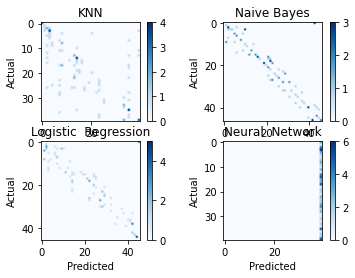

In [10]:
# Plot the confusion matrices for each classifier
import matplotlib.pyplot as plt
plt.subplot(221)
plt.title('KNN')
plt.imshow(cm_knn, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(222)
plt.title('Naive Bayes')
plt.imshow(cm_nb, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(223)
plt.title('Logistic  Regression')
plt.imshow(cm_lr, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(224)
plt.title('Neural  Network')
plt.imshow(cm_nn, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [15]:
# # Plot the ROC curves
# from sklearn.metrics import plot_roc_curve
# plot_roc_curve(knn, x_test, y_test)
# plot_roc_curve(nb, x_test, y_test)
# plot_roc_curve(lr, x_test, y_test)